# Ransac affine for point cloud alignment of two masks
In this tutorial we will learn to warp moving masks and examine point clouds (centriod of ROI) using two variants of the ransac affine and ICP algorithm. We can apply the ROI to extract images for later ROI_affine

Preprocessing for masks of moving rounds:
1. 3d starfinity segmentation of fixed round DAPI (segmentation masks)
2. filter ROI (remove non-neuron edge masks, merge over segmentation masks）
3. apply warp/invtransform to fixed round DAPI mask
4. remove noise on edge, mannually check the ROI shape

Steps for compare 2 rounds of masks, and export ROI_SPOTS
1. Extract ROI centriods as point cloud. Calculate the knn distance (20 pixels)
2. Ransac affine the point sets (<10% outlier, distance is 20 pixels). 
    a. spot extraction, context(no images any more), remove outlier by calculating correlation, ransac affine
    b. may add other information for the ROI_matching: # relative positions (distance to 3 nearest points), area (within 0.5-1.5), aspect_ratio.
    b.Visualize the masks and points
3. Use the ICP to minimize the distance of correponding ROIs. visualize the masks and points.Find the nearest ROIs using knn-neighbor. 

Bash
#maybe not necessary

#### input: 
1)segmentation mask of fixed rounds, 2) invtransformation, 3)extracted spots, 4)ROI_intensity info
#### output: 
1) segmentation mask of moving rounds, 2)point clouds of masks(center of each mask), 3) ROI index and meata,4) ROI_spots; 5) distance of warped ROI and real ROI (from the segmentation). 5. Generate excel for corresponding ROIs. 


We begin with loading the required modules.

In [6]:
# import pools
import os
import sys
import itertools
from math import pi, sin, cos, sqrt
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib import cm
from scipy import ndimage
import scipy.io
from skimage import data
from skimage.io import imread, imsave
import pandas as pd
from scipy.spatial import cKDTree
from cv2 import estimateTranslation3D
import tifffile
import seaborn as sns
from skimage.measure import regionprops
from scipy.spatial import distance

# import bigstream library
import zarr
from bigstream import ransac
from bigstream import transform

# napari
%gui qt5
import napari
# viewer = napari.view_image(data.astronaut(), rgb=True)
# napari.run()

We begin with loading the required modules for ransac.

In [2]:
def ransac_align_points(
    pA, pB, threshold, diagonal_constraint=0.75, default=np.eye(4)[:3],
):
    """
    """

    # sensible requirement of 51 or more spots to compute ransac affine
    if len(pA) <= 10 or len(pB) <= 10:
        if default is not None:
            print("Insufficient spot matches for ransac, returning default identity")
            return default
        else:
            raise ValueError("Insufficient spot matches for ransac, need more than 10")

    # compute the affine
    r, Aff, inline = cv2.estimateAffine3D(pA, pB, ransacThreshold=threshold, confidence=0.999)

    print(np.diag(Aff))
    print(Aff)
    print(diagonal_constraint)
    # rarely ransac just doesn't work (depends on data and parameters)
    # sensible choices for hard constraints on the affine matrix
    if np.any( np.diag(Aff) < diagonal_constraint ):
        if default is not None:
            print("Degenerate affine produced, returning default identity")
            return default
        else:
            raise ValueError("Degenerate affine produced, ransac failed")

    return Aff

### Colocalization filter 

In [7]:
def colocalization(spot_c0,spot_c1,neighbor_radius):
    # Fix and Mov true spots
#     neighbor_radius = math.sqrt(3*3*3) #3.464
    #vox=[0.23,0.23,0.38]
    c0=spot_c0[:,:3].copy()
    c1=spot_c1[:,:3].copy()

    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    # neighbors1 = kdtree_c0.query_ball_point(c1,neighbor_radius) #1 is all unique idx, 2 is the location
    # neighbors2 = kdtree_c0.sparse_distance_matrix(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
#     print(len(dist2[:,0])*3)
    
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat for only once
    #     print(Idx_unique[i])
        Loc_rep=np.where(idx2==Idx_unique[i])    
    #     print(Loc_rep[0])
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
    #     print(Loc_min)
    #     Loc_rep_min=Loc_rep[0][Loc_min[0]]    
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # when only first row is not exist use latter column, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
#     print(len(row_c1[0]))

    # lipo spot_c1 is row_c1
    pBind = row_c1[0]
    # print(idx2)
    # lipo spot_c1 is idx2
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
    lipo_c0 = spot_c0[pAind]
    lipo_c1 = spot_c1[pBind]

#     print(np.unique(pAind).shape)
    
    true_pos_c0 = np.delete(spot_c0, pAind, axis=0)
    true_pos_c1 = np.delete(spot_c1, pBind, axis=0) #true

    if spot_c0.shape[0]>0:
        P1 = (lipo_c0.shape[0] / spot_c0.shape[0])*100   # % mov spots from  previous images  /spot_c0.shape
    else:
        P1 = 0
        
    if spot_c1.shape[0]>0:
        P2 = (lipo_c1.shape[0] / spot_c1.shape[0])*100  # % fixed spots can be found in later mov images  /spot_c0.shape
    else:
        P2 = 0

    print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 

    Dist = eucldist(lipo_c0,lipo_c1)

    return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist

# compute distance of paired spot cloud
def cloud_distance(spot_fix,spot_mov):
    """
    """
    c0=spot_fix[:,:3].copy()
    c1=spot_mov[:,:3].copy()
    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    return dist2[:,0]

# euclidean_distances(lipo_c0,lipo_c1).shape
from sklearn.metrics.pairwise import euclidean_distances
def eucldist(coords1, coords2):
    """ Calculates the euclidean distance between 2 lists of coordinates. """
    dist = np.zeros(len(coords1))
    i = 0
    for (x, y) in zip(coords1, coords2):
        p1 = x
        p2 = y
        squared_dist = (p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2
        dist[i] = np.sqrt(squared_dist)
        i = i+1
    return dist
# dist = eucldist(lipo_c0, lipo_c1)
# print(dist)

def match_points(A, B, scores, threshold):
    """
    """
    scores = 0
    A1,B1,_,_,_ = colocalization(A,B,threshold)
    # return positions of corresponding points
    return A1,B1

def violin_distance(A, B):    
    fig=plt.figure(dpi=120,figsize=(2,3))
    plt.violinplot(cloud_distance(A,B))
    sns.despine() 
    plt.xlabel('Spots:'+ str(cloud_distance(A,B).shape[0]))
    plt.ylabel('Distance/pixel')
    ave=np.average(cloud_distance(A,B))
    plt.title(str(float('%.2f' % ave)))
    plt.show()
    plt.tight_layout()
    return ave

def pair_match(spot_c0,spot_c1,neighbor_radius):
    c0=spot_c0[:,:3].copy()
    c1=spot_c1[:,:3].copy()
    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat only once
        Loc_rep=np.where(idx2==Idx_unique[i])    
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # use latter column when only first row is not exist, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
    pBind = row_c1[0]
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
#     lipo_c0 = spot_c0[pAind]
#     lipo_c1 = spot_c1[pBind]
    Aind = spot_c0[pAind][:,3].astype(int)
    Bind = spot_c1[pBind][:,3].astype(int)
    return Aind,Bind

In [10]:
## ICP
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nx3 array of points
        dst: Nx3 array of points
    Output:
        distances: Euclidean distances (errors) of the nearest neighbor
        indecies: dst indecies of the nearest neighbor
    '''

    indecies = np.zeros(src.shape[0], dtype=np.int)
    distances = np.zeros(src.shape[0])
    for i, s in enumerate(src):
        min_dist = np.inf
        for j, d in enumerate(dst):
            dist = np.linalg.norm(s-d)
            if dist < min_dist:
                min_dist = dist
                indecies[i] = j
                distances[i] = dist
    return distances, indecies  

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A->B
    Input:
      A: Nx3 numpy array of corresponding 3D points
      B: Nx3 numpy array of corresponding 3D points
    Returns:
      T: 4x4 homogeneous transformation matrix
      R: 3x3 rotation matrix
      t: 3x1 column vector
    '''
    assert len(A) == len(B)

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0) 
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    W = np.dot(BB.T, AA)
    U, s, VT = np.linalg.svd(W, full_matrices=True, compute_uv=True)
    R = np.dot(U, VT)

    # special reflection case
    if np.linalg.det(R) < 0:
        VT[2,:] *= -1
        R = np.dot(U, VT)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t

    return T, R, t
       
def icp(A, B, ICP_error,init_pose = None, max_iterations=200, tolerance=0.001):
    '''
    The Iterative Closest Point method
    Input:
        A: Nx3 numpy array of source 3D points
        B: Nx3 numpy array of destination 3D point
        init_pose: 4x4 homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor
    '''
    #  select points 
#     ICP_error = 30
    A,B,_,_,_ = colocalization(A,B,ICP_error)
    
    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((4,A.shape[0]))  #(4, A.shape[0])
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)  # A.T shape (3,20)
    dst[0:3,:] = np.copy(B.T)
    
    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0
    distances_iter = np.zeros((max_iterations,1))

    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:3,:].T, dst[0:3,:].T)
        
        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)  
        # update the current source
    # refer to "Introduction to Robotics" Chapter2 P28. Spatial description and transformations
        src = np.dot(T, src)

        # check error
        mean_error = np.sum(distances) / distances.size
#         print(f'mean_error: {mean_error}')
#         if abs(prev_error-mean_error) < tolerance:
#             break
        prev_error = mean_error
        distances_iter[i] = mean_error
    
    fig=plt.figure(dpi=120,figsize=(2,3))
    plt.plot(distances_iter[:20])
    sns.despine() 
    plt.xlabel('Spots:'+ str(distances_iter[:20].shape[0]))
    plt.ylabel('Distance/pixel')
    ave=np.average(distances_iter[:20])
    plt.title(str(float('%.2f' % ave)))
    plt.show()
    # calculcate final tranformation
    T,_,_ = best_fit_transform(A, src[0:3,:].T)

    return T, distances     

In [9]:
####Get metadata for ROI: ID, centroid position, size, distance to (0,0,0) and aspect ratio####
def ROI_meta(segmentation,out_dir):
    lb = segmentation.astype(int)
    roi = np.max(lb)
    lb_id = np.unique(lb[lb != 0]) 
    df = pd.DataFrame(np.empty([lb_id.shape[0], 0]))
    lb_stat = regionprops(lb)
    ROI_points = np.empty([lb_id.shape[0],4])
    i = 0
    for j in lb_id: 
        df.loc[df.index[i], 'roi'] = j
        df.loc[df.index[i], 'x'] = lb_stat[i].centroid[0]
        df.loc[df.index[i], 'y'] = lb_stat[i].centroid[1]
        df.loc[df.index[i], 'z'] = lb_stat[i].centroid[2]
        df.loc[df.index[i], 'area'] = lb_stat[i].area
#         df.loc[df.index[i], 'Distance'] = distance.euclidean(lb_stat[i].centroid,[0,0,0])
        df.loc[df.index[i], 'minor_axis_length'] = lb_stat[i].minor_axis_length
        df.loc[df.index[i], 'major_axis_length'] = lb_stat[i].major_axis_length
        df.loc[df.index[i], 'aspect_ratio'] = lb_stat[i].minor_axis_length/lb_stat[i].major_axis_length
        ROI_points[i,:3] = lb_stat[i].centroid
        ROI_points[i,3] = j
        i = i+1
    ####Filter out ROIs that 1) not in mask; 2) have high background in channel 546
    list_ROI = [0]
    df_filtered=df.loc[~df['roi'].isin(list_ROI)]
    df_filtered.to_csv(out_dir, index=False)
    print(ROI_points.shape)
    return df_filtered,ROI_points

In [ ]:
# 1) correlation (corr > 0.999 in average intensity of 4 channels) 
# 2) less than 75 pixels apart(centroid position distance, for 3x expansion)
# 3) > 4% of cell volume contacting
# 4) for ROIs that have more than two corresponding pairs, the corresponding segments will be ranked by % of contacting, 
# and they will be flagged for manual inspection
# 5) if both segments are bigger than 20000 in size, it will be flagged and manually inspected
# 6) at least one of the segments have to be bigger than 7000 pixels in size

In [6]:
def downsegmentation_ROI(lb, r, out_dir, count_dir, Mean_int_dir, roi_dir):

# Would need to test if it is the same with Yuhan's orginal one with multiple rounds 

# Code used to flag over-segmentation errors for a single round. 
# A. maximize the number of identified errors
# B. minimize false detection of well-segemented cells 
# 
# The over-segmentation pairs are identified with the following criteria: 
# 1) the two segments have a very high correlation (corr > 0.999 in average intensity of 4 channels) 
# 2) the two segments have to be less than 75 pixels apart(centroid position distance, for 3x expansion)
# 3) The two segments have to be touching each other: at least one > 4% of cell volume contacting
# 4) for ROIs that have more than two corresponding pairs, the corresponding segments will be ranked by % of contacting, 
# and they will be flagged for manual inspection
# 5) if both segments are bigger than 20000 in size, it will be flagged and manually inspected
# 6) at least one of the segments have to be bigger than 7000 pixels in size
# #1，#2, #3, #4 are for initial identification of oversegmentation errors 
# #5, #6 are for eliminating the false detections  

#     count_dir      = seg_dir + 'R2_3tm50_1920/roi_spots_all.csv' # directory to spot count/neuron (csv format)
#     Mean_int_dir   = seg_dir + 'R2_mean_intensity.csv' # directory to mean intensity/neuron (csv format)
# #     roi_dir        = seg_dir + 'allroi_fix.csv'
#     lb_dir         = 'E:/Maxprobe_analysis/R2_R1_3tm50/mask2.tif' # directory to segmentation mask (tif format)
#     out_dir        = seg_dir

    df1=pd.read_csv(count_dir,sep=',', index_col=0) ## / change to count/area so that it can be comparable.
    df2=pd.read_csv(Mean_int_dir,sep=',', index_col=0)
    # df= pd.concat([df1, df2], axis=1)
    df = df2
    roi=pd.read_csv(roi_dir,sep=',',index_col=0)
    # roi=df_filtered_fix

    ###Get correlation matrix
    corr_raw =df.T.corr()
    s_raw = corr_raw.stack()
    ii_raw = s_raw[np.logical_and(s_raw > 0.999, s_raw<1.0)].index.tolist()
    test=np.asarray(ii_raw)
    test.sort(axis=1)
    test=np.unique(test,axis=0).astype(int)

    cand={}
    for i in range(0,len(test)):
        a=roi.loc[test[i,0]].to_numpy()[:3]
        b=roi.loc[test[i,1]].to_numpy()[:3]
        dist=distance.euclidean(a,b)
        if dist<75 and dist>0:  # for 3x expansion
            a_area=roi.loc[test[i,0]]['area']
            b_area=roi.loc[test[i,1]]['area']
            if np.maximum(a_area,b_area) >7000:
                c=corr_raw.loc[test[i,0],test[i,1]]
                cand[i] = np.append(test[i,:],c)
                cand[i] = np.append(cand[i],dist)
                if np.minimum(a_area,b_area) >20000:
                    cand[i]=np.append(cand[i], str(np.minimum(a_area,b_area)))
                else:
                    cand[i]=np.append(cand[i], str('--'))

    m=pd.DataFrame.from_dict(data=cand, orient='index')
    m = m.rename(columns={0:'cell_A', 1:'cell_B', 2: 'corr', 3:'dist',4: 'min_size_20000'})
    m['cell_A'], m['cell_B'] = np.where(m['cell_A'] > m['cell_B'], [m['cell_B'],m['cell_A'] ], [m['cell_A'] , m['cell_B']])

    ### % of cell volume contacting
#     lb=imread(lb_dir)
    lb_stat=regionprops(lb)
    select={}            
    ROI_row =[]
    ROI_row_1 =[]
    ROI_row_2 =[]
    ROI_row_3 =[]
    ROI_row_4 =[]

    kk = 0
    ROI_merge = {}
    ROI_remove = []
    for k in range(0,len(m)):
        id1=m.iloc[k]['cell_A'].astype(np.float).copy()
        id2=m.iloc[k]['cell_B'].astype(np.float).copy()
        a=lb_stat[int(id1-1)].coords
        b=lb_stat[int(id2-1)].coords
        kdtree_a = cKDTree(a)
        kdtree_b = cKDTree(b)
        nnn=kdtree_a.count_neighbors(kdtree_b,1)    
        edge_ratio_a = 100*nnn/roi.loc[id1]['area'].astype(int)
        edge_ratio_b = 100*nnn/roi.loc[id2]['area'].astype(int)

        if nnn>0:
            select[k]=m.iloc[k]
            # edge_ratio_a
            if edge_ratio_a<4:
    #             select[k]=np.append(select[k], str('less_100'))
                select[k]=np.append(select[k], str('less_4%')) 
            else:
                select[k]=np.append(select[k], str(edge_ratio_a)) # ('--')
            # edge_ratio_b    
            if edge_ratio_b<4:
    #             select[k]=np.append(select[k], str('less_100'))
                select[k]=np.append(select[k], str('less_4%')) 
            else:
                select[k]=np.append(select[k], str(edge_ratio_b)) # ('--')

            if (edge_ratio_b < 4) and (edge_ratio_a < 4):    
                select[k]=np.append(select[k], str('--')) # ('--')
            else:
                # get all rows
                ROI_merge1 = [int(id1),int(id2),edge_ratio_a,edge_ratio_b]
                ROI_merge[kk] = ROI_merge1 # ('--')
                kk = kk + 1
                # 'cell_B' can be only merge to one 'cell_A': find the biggest edge_ratio_b;      
                select[k]=np.append(select[k], str('merge'))
                # 'cell_A' can be only merge to one 'cell_B': find the biggest edge_ratio_a;  

    ### generate oversegmentation list
    select=pd.DataFrame.from_dict(data=select, orient='index')
    select = select.rename(columns={0:'cell_A', 1:'cell_B', 2: 'corr', 3:'dist',4: 'min_size_20000',5:'touch_A',6:'touch_B',7:'Merge'})
    select.to_csv(out_dir + '/'+ r + '_oversegmentation.csv')

    ### automatic merge oversegmenation masks when touching ratio > 4%
    n=pd.DataFrame.from_dict(data=ROI_merge, orient='index')
    n = n.rename(columns={0:'cell_A', 1:'cell_B', 2: 'touch_A', 3:'touch_B'})
    for j in range(0,kk):    
        # 'cell_A' can be only merge with one 'cell_B': find the biggest edge_ratio_a; 
        ROI_merge_B = n.iloc[j]['cell_B'].astype(np.int32).copy()
        ROI_row = list(np.where(n['cell_B'] == ROI_merge_B))[0]
        if ROI_row.shape[0] > 1:
            ROI_row_1 = list(np.where(ROI_row != n['touch_A'][ROI_row].idxmax())[0])
    #         print(list(ROI_row[ROI_row_1]))
            ROI_row_2 = np.array(list(set(ROI_row_2).union(set(list(ROI_row[ROI_row_1])))))

        # 'cell_B' can be only merge to'cell_A' once: find the biggest edge_ratio_b;
        ROI_merge_A = n.iloc[j]['cell_A'].astype(np.int32).copy()
        ROI_row = list(np.where(n['cell_A'] == ROI_merge_A))[0]
        if ROI_row.shape[0] > 1:
            ROI_row_3 = list(np.where(ROI_row != n['touch_B'][ROI_row].idxmax())[0])
            ROI_row_4 = np.array(list(set(ROI_row_4).union(set(list(ROI_row[ROI_row_3])))))
        # delete select row.
    ROI_remove  = list(np.array(set(ROI_row_4).union(set(ROI_row_2))).tolist())
    ROI_keep = list(np.array(set(range(kk)).difference(set(ROI_remove))).tolist())
    ROI_select = [n.iloc[i][['cell_A','cell_B','touch_A','touch_B']] for i in list(ROI_keep)]
    ROI_select=pd.DataFrame(ROI_select) 
    ROI_select.to_csv(out_dir + '/'+ r + '_oversegmentation_final.csv')  
    return ROI_select

def merge_ROI(lb, ROI_select):
    # Merge list
    A = np.array(ROI_select.values.tolist())[:,0].astype(int) # cell_A
    B = np.array(ROI_select.values.tolist())[:,1].astype(int) # cell_B
    C = list(np.array(set(A).intersection(set(B))).tolist()) # replicate list
    row_C = [list(np.where(A == i)[0])[0] for i in C]  
    lb_vary = lb.copy()
    for i in C: #Merge replicate roi first        
        row_A = A[np.where(A == i)]
        row_B = B[np.where(A == i)] # find the row 
        # merge row_C = i
        lb_vary[np.where(lb_vary==row_B)] = row_A
        
    # remove the row_B from list
    A = np.delete(A, row_C, axis=0) 
    B = np.delete(B, row_C, axis=0) 
    ii = 0
    for j in A :   
    # merge A and B
        lb_vary[np.where(lb_vary==B[ii])] = j
        ii = ii +1
    return(lb_vary)

In [58]:
def integrated_intensity(regionmask, intensity_image):
    return np.sum(intensity_image)

def ROI_intensity(lb,puncta_path, r, df_filtered):
    # calculate ROI mean intensity for four channels
    roi= np.unique(lb[lb != 0])
    df_mean = pd.DataFrame(data=np.empty([len(roi),1]), columns=['roi'], dtype=object)
    df_integrated = pd.DataFrame(data=np.empty([len(roi),1]), columns=['roi'], dtype=object)
    im = zarr.open(store=zarr.N5Store(puncta_path), mode='r')
    cc = ['c0','c1','c2','c3']
    
    for c in cc:
        img = im[c +'/s2'][...]
        if c == 'c3':
            dapi=im['c2/s2'][...]
            lo=np.percentile(np.ndarray.flatten(dapi),99.5)
            bg_dapi=np.percentile(np.ndarray.flatten(dapi[dapi!=0]),1)
            bg_img=np.percentile(np.ndarray.flatten(img[img!=0]),1)
            dapi_factor=np.median((img[dapi>lo] - bg_img)/(dapi[dapi>lo] - bg_dapi))
            img = np.maximum(0, img - bg_img - dapi_factor * (dapi - bg_dapi)).astype('float32')
        elif c == 'c2':
            img = im['c2/s2'][...] 
        else:
            dapi=im['c2/s2'][...]
            lo=np.percentile(np.ndarray.flatten(dapi),99.5)
            bg_dapi=np.percentile(np.ndarray.flatten(dapi[dapi!=0]),1)
            bg_img=np.percentile(np.ndarray.flatten(img[img!=0]),1)
            dapi_factor=0
            img = np.maximum(0, img - bg_img - dapi_factor * (dapi - bg_dapi)).astype('float32') 

        lb_stat = regionprops(lb,intensity_image=img,extra_properties=(integrated_intensity,))
        for i in range(0,len(roi)):
            df_mean.loc[i, 'roi'] = lb_stat[i].label
            df_integrated.loc[i, 'roi'] = lb_stat[i].label
            df_mean.loc[i, r+'_'+c+'_mean_intensity'] = lb_stat[i].mean_intensity
            df_integrated.loc[i, r+'_'+c+'_integrated_intensity'] = lb_stat[i].integrated_intensity  
            
    df_mean.to_csv(seg_dir + r + '_mean_intensity.csv', index=False)
    df_integrated.to_csv(seg_dir + r + '_integrated_intensity.csv', index=False)
    return df_mean,df_integrated

def non_neuron_ROI(df_mean,df_filtered,r):    
    
    # calculate ROI mean intensity for four channels
    # remove low expressor of C0C3 ratio
    # remove small area 1.5*ratio
    
    print('ROI mean intensity for channels:c0-c3')
    ratio = 2
#     df_integrated = pd.read_csv(seg_dir + r + '_integrated_intensity.csv',sep=',', index_col=0)
    n,b=np.histogram(df_mean[r+'_c0_mean_intensity'].values, bins=5000)    
    thres0=b[np.argwhere(n == n.max())][0][0]*ratio
    print(thres0)
    n,b=np.histogram(df_mean[r+'_c1_mean_intensity'].values, bins=5000)    
    thres1=b[np.argwhere(n == n.max())][0][0]*ratio
    print(thres1)
    n,b=np.histogram(df_mean[r+'_c2_mean_intensity'].values, bins=5000)    
    thres2=b[np.argwhere(n == n.max())][0][0]*ratio
    print(thres2)
    n,b=np.histogram(df_mean[r+'_c3_mean_intensity'].values, bins=5000)    
    thres3=b[np.argwhere(n == n.max())][0][0]*ratio
    print(thres3)
    ROI_c0 = np.where(df_mean[r+'_c0_mean_intensity'].values < thres0)[0]
    ROI_c1 = np.where(df_mean[r+'_c1_mean_intensity'].values < thres1)[0]
    ROI_c2 = np.where(df_mean[r+'_c2_mean_intensity'].values < thres2)[0]
    ROI_c3 = np.where(df_mean[r+'_c3_mean_intensity'].values < thres3)[0]

    ROI_c0 = df_mean['roi'][ROI_c0].tolist()
    ROI_c1 = df_mean['roi'][ROI_c1].tolist()
    ROI_c2 = df_mean['roi'][ROI_c2].tolist()
    ROI_c3 = df_mean['roi'][ROI_c3].tolist()
    ROI_c3_c0 = np.array(list(set(ROI_c0).intersection(set(ROI_c3)))) # intersection？ 
    # print(ROI_c3_c0.shape[0])
    ROI_cx = ROI_c3_c0
#     ROI_cx = np.array(list(set(ROI_c3_c0).intersection(set(ROI_c2))))
    print('lowerexpressorinc0c3:' + str(len(ROI_c3_c0)))
    
    # remove small area
    n,b=np.histogram(df_filtered['area'].values, bins=5000)    
    thres=b[np.argwhere(n == n.max())][0][0]*1.5*ratio
    print('areas>'+ str(np.round(thres)))
    ROI_area =np.where(df_filtered['area'] < thres)[0]
    ROI_area = df_filtered['roi'][ROI_area].tolist()
    print('smallroi:' + str(len(ROI_area)))
    
    ROI_non_neuron = np.array(list(set(ROI_cx).union(set(ROI_area))))
    print('non_neuron_ROI:' + str(len(ROI_non_neuron))) 
    
    return ROI_non_neuron,ROI_cx,ROI_area

In [8]:
def ROI_spot(out_dir,lb,spot_dir,rr,s):
    
#     roi_dir            = out_dir + 'roi_all.csv'   # directory to file containing the ROI metadata (neuron volume, etc.)
#     spot_dir           = out_dir + 'R1_3tm50_1920/*.txt'  # directory to folder of airlocalize output (1 file/gene, txt format)
#     spotcount_dir      = out_dir + 'R1_3tm50_1920/roi_spots_all.csv'   # directory to assignedhen spots per neuron based on airlocalize (csv format)
#     output_dir         = out_dir + 'R1_3tm50_1920/Dense_spotcount.csv' # directory where output should be stored
    
    ## found spot with the roi 
    # lb = imread(lb_dir)      
    lb_id = np.unique(lb[lb != 0])
    z, y, x = lb.shape
    a = 0
#     s = [0.92,0.92,0.84]  ## voxel size in segmentation image [0.23, 0.23, 0.42] 
    count = pd.DataFrame(np.empty([len(lb_id), 0]), index=lb_id)
    fx=sorted(glob(spot_dir))     # in um
    for f in fx:
        r=os.path.basename(f).split('.')[0]
        spot=np.loadtxt(f, delimiter=',')                  
        print("Load:", f)
        # convert from physical unit to pixel unit 
        rounded_spot = np.round(spot[:, :3]/s).astype('int')    ############## every spot location in pixel
        df = pd.DataFrame(np.zeros([len(lb_id), 1]),
                          index=lb_id, columns=['count'])    ## only for count
        spot=np.append(spot, np.zeros((len(spot),1)), axis=1)  ############ every spot location in um ## add last column    
        n = len(spot)
        for i in range(0, n):                 ## lb = all the valid ROI
            if np.any(np.isnan(spot[i,:3])):  ## spot[i,:3]   ##if spot located outside of segmentation image
                print('NaN found in {} line# {}'.format(f, i+1))
            else:
                if np.any(spot[i,:3]<0):
                    a = a + 1
                else:
                    try:
                        Coord = rounded_spot[i]
                        idx = lb[Coord[2]-1, Coord[1]-1, Coord[0]-1]   # roi id                     
                        if idx > 0 and idx <= np.max(lb_id):
                            df.loc[idx, 'count'] = df.loc[idx, 'count']+1
                            spot[i,4]=idx  # add ROI number                                       
                    except Exception as e:  # outside of ROIs
                        a = a + 1

        spot_int=spot[spot[:,4]!=0]
        print(spot_int.shape)
        np.savetxt(out_dir  + 'RS-FISH/' + r +'_ROI.txt'.format(r),spot_int,delimiter=',')  
        ## found count with the roi_num  
        count.loc[:, r] = df.to_numpy() # r

    out_dir1 = out_dir + 'RS-FISH/' + rr + '_spots_all.csv'
    count.to_csv(out_dir1)
    # also save to txt.
    # spotcount=pd.read_csv(spotcount_dir,sep=',', index_col=0)
    return count

In [59]:
def filterROI(seg_dir,lb_origin,puncta_path,df_filtered,r):
    """
    Remove ROI on the edges or not complete. 
    # Integrate list of ROIs that on the edges (are usually not been well aligned)
    """
    # 1.remove oversegmentation ROIs: export oversegmented ROI pairs, with some flagged for manual inspection. 
    count_dir      = seg_dir + r +'_spots_all.csv'  # directory to spot count/neuron (csv format)
    Mean_int_dir   = seg_dir + r +'_mean_intensity.csv' # directory to mean intensity/neuron (csv format)
    roi_dir        = seg_dir + r + '_allroi.csv'
    ROI_select=downsegmentation_ROI(lb_origin,r,seg_dir,count_dir, Mean_int_dir, roi_dir)
    
#     pd.read_csv(out_dir+'/flag_oversegmentation_final.csv',sep=',', index_col=0)
#     ROI_select=pd.DataFrame(ROI_select) 
    # After manual inspection, the list can be used to merge the oversegmented ROI pairs.
    lb_merge = merge_ROI(lb_origin, ROI_select)
    print(np.unique(lb_merge).shape[0])
#     viewer.add_image(lb_merge,colormap='green',blending='additive') #load image data into napari
    
    # 2. to remove the ROIs on the edges.
    lb = lb_merge.copy()
    z, y, x = lb.shape
    lb_id = np.unique(lb[lb != 0])
    grid = np.array([lb.shape[0],lb.shape[1],lb.shape[2]])        ## need clarify
    mask1=np.full((grid[0], grid[1], grid[2]),1)
    edge_dist = 1
    mask1[:,:,:edge_dist]=0  # x_1
    mask1[:,:,x-edge_dist:x]=0  # x_end
    mask1[:,:edge_dist,:]=0  # y_1
    mask1[:,y-edge_dist:y,:]=0  # y_end
    mask1[:edge_dist,:,:]=0 # First
    mask1[z-edge_dist:z,:,:]=0 # Last
    ROI_edge=np.unique(lb[mask1==0])    
    print("# of edge cells rejected:", str(len(ROI_edge)) + "/" + str(len(np.unique(lb))))
    
    # 3.Remove these low expresser ROI that indicate non-neurons
    #### generate new ROI_meta.csv
    out_dir = seg_dir + r + 'mergeroi.csv'
    df_filtered_merge,ROI_points_fix = ROI_meta(lb_merge, out_dir)
    #### generate new df_integrated.csv
    df_mean,df_integrated = ROI_intensity(lb_merge, puncta_path, r, df_filtered_merge)
    
    ROI_non_neuron,ROI_cx,ROI_area = non_neuron_ROI(df_mean,df_filtered_merge, r)

    # 4.failed to be imaged in certain FISH round(s)    
    # remove all bad masks
    lb_edge = np.array(list(set(ROI_edge).union(set(ROI_non_neuron))))
    print("# of cells rejected:", str(len(lb_edge)) + "/" + str(len(np.unique(lb))))   
    # remaining masks
    lb_id1 = np.array(list(set(lb_id).difference(set(lb_edge))))
    
    lb_1 = lb.copy()
    for b in lb_edge:
        lb_1=np.where(lb_1==b,0,lb_1)
#     lb_1 = lb - lb_1
    print(len(np.unique(lb_1[lb_1 != 0])))
    
#     ## save new txt of ROI spots
#     spot_dir = seg +'R1_*.txt'
#     fx=sorted(glob(spot_dir))     # in um
#     for f in fx:
#         r=os.path.basename(f).split('.')[0]
#         spot=np.loadtxt(f, delimiter=',')  
#         spot_int=spot[spot[:,4]!=lb_edge]
#         np.savetxt(out_dir  + r +'_ROI_new.txt'.format(r),spot_int,delimiter=',') 
    return lb_1,lb_id1,lb_edge

In [10]:
### transform masks
import nrrd
from skimage.io import imread, imsave
import zarr
from scipy.ndimage import map_coordinates
from scipy.ndimage import distance_transform_edt

def interpolate_image(img, X, order=1):
    """Interpolate image at coordinates X"""
    X = np.moveaxis(X, -1, 0)
    return map_coordinates(img, X, order=order, mode='constant')

def read_n5_transform(n5_path, subpath):
    txm_n5 = zarr.open(store=zarr.N5Store(n5_path), mode='r')
    grid = txm_n5['/c0'+subpath].shape[::-1]
    txm = np.empty(grid + (3,))
    txm[..., 0] = txm_n5['/c0'+subpath][...].transpose(2,1,0)
    txm[..., 1] = txm_n5['/c1'+subpath][...].transpose(2,1,0)
    txm[..., 2] = txm_n5['/c2'+subpath][...].transpose(2,1,0)
    return txm

def expand_labels(label_image, distance=1):
    
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True)
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

## Filter segmented ROIs for fixed round

#### load masks and images

In [11]:
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/' # 
r1 = 'R2'
segmentation1=imread(seg_dir + 'mask2.tif') # fix round
fix_path = 'E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/stitching/export.n5/c2/s2'  # R2_CO
fix_zarr = zarr.open(store=zarr.N5Store(fix_path), mode='r')
img_fix = fix_zarr[...]
viewer = napari.view_image(data.astronaut(), rgb=True)
napari.run()
viewer.add_image(segmentation1,colormap='green',blending='additive') #load image data into napari
viewer.add_image(img_fix,colormap='green',blending='additive') #load image data into napari

r2 = 'R1'
segmentation2=imread(seg_dir + 'mask1.tif') # before or after global affine
fix_path = 'E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920/stitching/export.n5/c2/s2'  # R2_CO
fix_zarr = zarr.open(store=zarr.N5Store(fix_path), mode='r')
img_mov = fix_zarr[...]
viewer.add_image(segmentation2,colormap='red',blending='additive') #load image data into napari
viewer.add_image(img_mov,colormap='red',blending='additive') #load image data into napari

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img_mov' at 0x17334564e50>

#### Preprocessing of fixed ROI:  get roi mega data, mean intensity, roi spots count, and save roi in txt to seg_dir

In [12]:
%%time
from glob import glob 
# get roi meta data
out_dir = seg_dir + r1 + '_allroi.csv'
df_filtered1,ROI_points_fix = ROI_meta(segmentation1,out_dir)
# get roi mean intensity
puncta_path1 = seg_dir + 'R2_3tm50_1920/stitching/export.n5'
df_mean1,df_integrated1 = ROI_intensity(segmentation1,puncta_path1, r1, df_filtered1)

# get roi spots count  save roi in txt to seg_dir
s = [0.92,0.92,0.84]
spot_dir1 = seg_dir + 'R2_3tm50_1920/*.txt'
count1 = ROI_spot(seg_dir,segmentation1,spot_dir1,r1,s)

(1126, 4)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920\R2_c0.txt
(168668, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920\R2_c1.txt
(997, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920\R2_c3.txt
(167949, 5)
CPU times: total: 1min 56s
Wall time: 2min 12s


#### filter ROIs and save new fixed masks

In [61]:
%%time
### remove oversegmentation/low expressed/non-neurons/edges ROI, and save new txt to seg_dir with limited ROIs
lb_1,lb_id1,lb_edge1 = filterROI(seg_dir,segmentation1,puncta_path1,df_filtered1,r1)

imsave(seg_dir + r1 + '_filtered_mask.tif',lb_1)
### get images of FISH, check the effects after filtering ROIs
viewer.add_image(lb_1,colormap='green',blending='additive') #load image data into napari
### get new roi meta data
out_dir = seg_dir + r1 + '_mergeroi.csv'
df_filtered1,ROI_points_fix = ROI_meta(lb_1,out_dir)

C:\Users\zhenggang\AppData\Local\Temp\ipykernel_24928\3721346904.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  id1=m.iloc[k]['cell_A'].astype(np.float).copy()
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_24928\3721346904.py:75: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  id2=m.iloc[k]['cell_B'].astype(np.float).copy()


857
# of edge cells rejected: 220/857
(856, 4)
ROI mean intensity for channels:c0-c3
8.604130909729005
7.6836485955238345
508.81117026899005
3.823120129287243
lowerexpressorinc0c3:250
areas>9304.0
smallroi:209
non_neuron_ROI:371
# of cells rejected: 517/857
340


<timed exec>:4: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_filtered_mask.tif is a low contrast image


(340, 4)
CPU times: total: 10min 18s
Wall time: 10min 21s


#### save new ROI and spots information after new mask generated.

In [85]:
# get roi mega data
out_dir = seg_dir + r1 + '_allroi.csv'
df_filtered1,ROI_points_fix = ROI_meta(lb_1,out_dir)
# get roi mean intensity
puncta_path1 = seg_dir + 'R2_3tm50_1920/stitching/export.n5'
df_mean1,df_integrated1 = ROI_intensity(lb_1,puncta_path1, r1, df_filtered1)
# get roi spots count  save roi in txt to seg_dir
spot_dir1 = seg_dir + 'R2_3tm50_1920/*.txt'
count1 = ROI_spot(seg_dir,lb_1,spot_dir1,r1,s)
### np.savetxt center points of cell
np.savetxt(seg_dir + r1 + 'ROI_points_fix.txt', ROI_points_fix, delimiter=',')   # X is an array

(340, 4)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920\R2_c0.txt
(109506, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920\R2_c1.txt
(607, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920\R2_c3.txt
(106936, 5)


#### napari viewer for point sets of ROI

In [86]:
A = ROI_points_fix[:,:3]
# part of visualization only select z plane
Amax = max(A[:,0])
Amax = np.round(Amax/2).astype(int)*0
viewer.add_points(np.transpose(np.array([A[:,0][A[:,0] > Amax],A[:,1][A[:,0] > Amax],A[:,2][A[:,0] > Amax]])),name ='fixed_ROI', size=1,
                  face_color='green',edge_color='green',blending='opaque')

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'fixed_ROI [2]' at 0x173a24e0220>

## Transform fixed ROIs to get moving ROIs

In [87]:
### transform masks
lb_1 = imread(seg_dir + r1 + '_filtered_mask.tif')
txm_path = 'E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920/registration/R1_3tm50_1920-to-R2_3tm50_1920/invtransform'
local_warps=[]
local_warps=read_n5_transform(txm_path, '/s2')
z1_spacing=[0.92,0.92,0.84]
label_moving  = interpolate_image(lb_1.transpose(2,1,0), local_warps/z1_spacing)
label_moving1 = label_moving.transpose(2,1,0)
viewer.add_image(lb_1,colormap='red',blending='additive') #load image data into napari
viewer.add_image(label_moving1,colormap='red',blending='additive') #load image data into napari

<Image layer 'label_moving1' at 0x173985cae80>

### remove noise from transformation

In [88]:
%%time
from skimage import morphology
from skimage import filters
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops, find_contours,regionprops_table
import cv2
from PIL import Image
from scipy import ndimage as ndi

# Small spurious objects are easily removed by setting a minimum size for valid objects.
width = 3
remove_holes = morphology.remove_small_holes(label_moving1, width ** 3)  # transform to binary images 
remove_objects = morphology.remove_small_objects(remove_holes, width ** 3) # transform smaller object to 0 
# remove_objects = morphology.remove_small_objects(label_moving1, width ** 3)
# remove_objects = remove_holes
# set 0 where remove_objects is false
lb_11 = np.where(remove_objects == False,0,label_moving1)

#find edge
edges = filters.scharr(lb_11) # with smoothing weights [3, 10, 3].
# edges = filters.sobel(label_moving1) # approximates the gradient of the image intensity, and is fast to compute

#remove ROI's edge
lb_22 = np.where(edges!=0,0,lb_11)
#fill a hole
# Smooth images not return label.
#expand images
lb_33 = expand_labels(lb_22,width+1)

#remove noise
lb_id_1 = np.unique(lb_1[lb_1 != 0])
lb_id_2 = np.unique(lb_33[lb_33 != 0])
noise = list(set(lb_id_2).difference(set(lb_id_1)))
for i in noise:
#     lb_final  = np.where(lb_thresholded==False,0,lb_11)
    lb_33[lb_33==i] = 0
# reshape the label to moving image size
z, y, x = lb_33.shape
lb_final = np.where(img_mov!=0,0,img_mov)
lb_final[0:z,0:y,0:x] = lb_33

# viewer.add_image(remove_holes,colormap='green',blending='additive') #load image data into napari
# viewer.add_image(remove_objects,colormap='green',blending='additive') #load image data into napari
# viewer.add_image(lb_11,colormap='green',blending='additive') #load image data into napari
# viewer.add_image(edges,colormap='magenta',blending='additive') #load image data into napari
# viewer.add_image(lb_22,colormap='green',blending='additive') #load image data into napari
viewer.add_image(lb_final,colormap='green',blending='additive') #load image data into napari

#save image
imsave(seg_dir + r2 + '_filtered_mask.tif',lb_final)

C:\Users\zhenggang\AppData\Roaming\Python\Python38\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)
<timed exec>:49: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R1_filtered_mask.tif is a low contrast image


CPU times: total: 1min 26s
Wall time: 1min 28s


In [62]:
# # visualize any ROI mask
# lb_111 = np.where(label_moving1 == 2,0,label_moving1)
# lb_111 = label_moving1 - lb_111
# viewer.add_image(lb_111,colormap='green',blending='additive')

#### Examine the transform

In [89]:
# txm_path = 'E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920/registration/R1_3tm50_1920-to-R2_3tm50_1920/transform'
# transform=read_n5_transform(txm_path, '/s2')
# txm_path = 'E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920/registration/R1_3tm50_1920-to-R2_3tm50_1920/invtransform'
# invtransform=read_n5_transform(txm_path, '/s2')
# viewer.add_image(transform[...,2].transpose(2,1,0),colormap='green',blending='additive') #load image data into napari
# viewer.add_image(invtransform[...,2].transpose(2,1,0),colormap='magenta',blending='additive') #load image data into napari

# label_moving  = interpolate_image(lb_final.transpose(2,1,0), local_warps2/z1_spacing)
# label_moving1 = label_moving.transpose(2,1,0)
# viewer.add_image(label_moving1,colormap='red',blending='additive') #load image data into napari
ROI_points_mov

array([[4.45945066e+01, 1.59354190e+02, 2.45066401e+02, 1.00000000e+00],
       [1.45344785e+02, 8.36934360e+01, 1.29149708e+02, 2.00000000e+00],
       [5.51829214e+02, 1.16440094e+02, 2.44152710e+02, 3.00000000e+00],
       ...,
       [2.77010120e+02, 1.30587173e+02, 1.44535544e+02, 1.11700000e+03],
       [1.59494549e+02, 3.76715412e+02, 3.74647248e+02, 1.12000000e+03],
       [5.02615652e+02, 3.05281342e+02, 3.84790062e+01, 1.12500000e+03]])

In [90]:
ROI_points_fix

array([[3.59945201e+01, 1.93201773e+02, 2.32666537e+02, 1.00000000e+00],
       [1.34218029e+02, 9.63127705e+01, 1.25833053e+02, 2.00000000e+00],
       [5.64276772e+02, 1.23176203e+02, 2.60613890e+02, 3.00000000e+00],
       ...,
       [2.72085975e+02, 1.37709835e+02, 1.44515898e+02, 1.11700000e+03],
       [1.62456609e+02, 4.14265804e+02, 3.53872324e+02, 1.12000000e+03],
       [5.11834667e+02, 2.93088400e+02, 3.40238170e+01, 1.12500000e+03]])

### Postprocessing for moving ROI:  get roi mega data, mean intensity, roi spots count, and save roi in txt to seg_dir 

In [91]:
%%time
# get roi mega data
segmentation2 = lb_final
out_dir = seg_dir + r2 + '_allroi.csv'
df_filtered2,ROI_points_mov = ROI_meta(segmentation2,out_dir)
# get roi mean intensity
puncta_path2 = seg_dir + 'R1_3tm50_1920/stitching/export.n5'
df_mean2,df_integrated2 = ROI_intensity(segmentation2,puncta_path2, r2, df_filtered2)
# get roi spots count  save roi in txt to seg_dir
spot_dir2 = seg_dir + 'R1_3tm50_1920/*.txt'
count2 = ROI_spot(seg_dir,segmentation2,spot_dir2,r2,s)
np.savetxt(seg_dir + r2 + 'ROI_points_mov.txt', ROI_points_mov, delimiter=',')   # X is an array

(340, 4)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920\R1_c0.txt
(132037, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920\R1_c1.txt
(1373, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920\R1_c3.txt
(140053, 5)
CPU times: total: 1min 53s
Wall time: 2min 3s


#### check the effects after filtering moving ROIs by comparing to the images of FISH 

In [ ]:
viewer.add_image(lb_1,colormap='green',blending='additive') #load image data into napari
viewer.add_image(lb_final,colormap='red',blending='additive') #load image data into napari

### Calculate the cell distance before and after bigstream registration

In [92]:
spotdir = seg_dir + r1 + 'ROI_points_fix.txt'
spot_fix=np.loadtxt(spotdir, delimiter=',')
segmentation1=imread(seg_dir + r2 + '_filtered_mask.tif') # fix round
out_dir = seg_dir + r2 + '_allroi.csv'
_,ROI_points_mov = ROI_meta(segmentation1,out_dir)
A,B,_,_,dist= colocalization(ROI_points_mov,spot_fix,100)
print("Cell distance before bigstream registration:", str(np.mean(dist)),"px")
# violin_distance(A, B)
spotdir = seg_dir + r2 + 'ROI_points_mov.txt'
spot_mov_old=np.loadtxt(spotdir, delimiter=',')
A,B,_,_,dist= colocalization(ROI_points_mov,spot_mov_old,100)
print("Cell distance after bigstream registration:", str(np.mean(dist)),"px")
# violin_distance(A, B)

(340, 4)
% P1:  87.05882352941177;  % P2:  87.05882352941177
Cell distance before bigstream registration: 23.364955111434952 px
% P1:  100.0;  % P2:  100.0
Cell distance after bigstream registration: 0.0 px


#### napari viewer for point sets of ROI

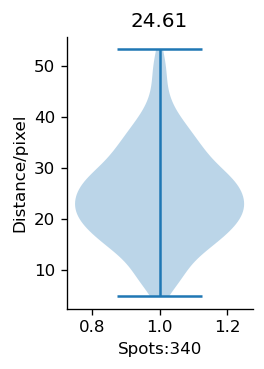

<Figure size 432x288 with 0 Axes>

In [93]:
A = ROI_points_fix[:,:3]
B = ROI_points_mov[:,:3]

# part of visualization only select z plane
Amax = max(A[:,0])
Amax = np.round(Amax/2).astype(int)*0
Bmax = max(B[:,0])
Bmax = np.round(Bmax/2).astype(int)*0

# viewer.add_points(np.transpose(np.array([A[:,0][A[:,0] > Amax],A[:,1][A[:,0] > Amax],A[:,2][A[:,0] > Amax]])),name ='fixed_ROI', size=1,
#                   face_color='green',edge_color='green',blending='opaque')
# viewer.add_points(np.transpose(np.array([B[:,0][B[:,0] > Bmax],B[:,1][B[:,0] > Bmax],B[:,2][B[:,0] > Bmax]])),name ='moving_ROI', size=1,
#                   face_color='magenta',edge_color='magenta',blending='opaque') 
dist_raw = violin_distance(A, B)

## Locate the ID of corresponding ROIs
#### Need correlational method that calculates the mutual information, e.g. area, aspect, not only the center of ROI. 


#### not necessary but here is to register cells of two rounds, try to find the correspondence.

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


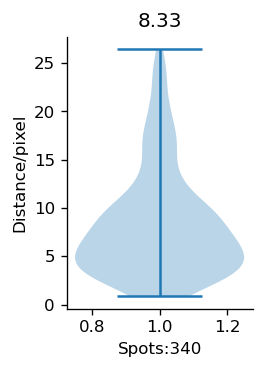

% P1:  16.341030195381883;  % P2:  54.11764705882353


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_24928\93186866.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


<Figure size 432x288 with 0 Axes>

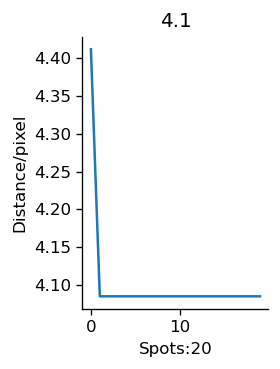

% P1:  54.11764705882353;  % P2:  16.341030195381883


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_24928\93186866.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


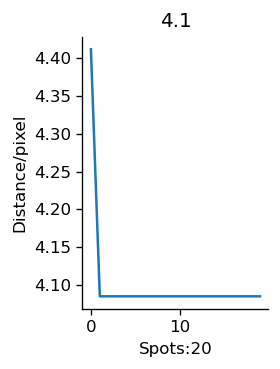

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


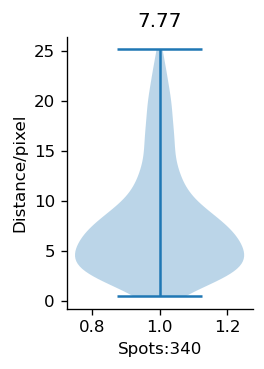

<Figure size 432x288 with 0 Axes>

In [72]:
# after global affine, apply inv_affine matrix to the mov_masks
from numpy import genfromtxt
inv_affine = genfromtxt(seg_dir + 'R2R1_invaffine.csv',delimiter=',')

p = np.append(B, np.ones((B.shape[0],1)), axis=1)
ROI_points_icp_ransac = p.dot(inv_affine.T)

G = ROI_points_icp_ransac[:,:3]
viewer.add_points(np.transpose(np.array([G[:,0],G[:,1],G[:,2]])),name ='RANSAC_ROI', size=1,
                  face_color='red',edge_color='red',blending='opaque') 
dist_Ransac = violin_distance(A, G)

#apply ICP
# G=B
ROI_points_warp=[]
Transform, distances1 = icp(A, G, dist_raw/3)
inv_Transform, distances2 = icp(G, A, dist_raw/3)
p = np.append(G, np.ones((G.shape[0],1)), axis=1)
ROI_points_warp = p.dot(inv_Transform.T)[:,:3]
C = ROI_points_warp[:,:3]
viewer.add_points(np.transpose(np.array([C[:,0],C[:,1],C[:,2]])),name ='ICP_ROI', size=1,
                  face_color='red',edge_color='red',blending='opaque')
dist_ICP = violin_distance(A, C)

In [254]:
# ===========calculate FPFH for pcd==========
def FPFH_Compute(pcd,r1,r2):
    
    import open3d as o3d
    radius_normal = r1  # kdtree estimate radius 0.01
#     print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    radius_feature = r2  # kdtree estimate FPFH feature radius 0.02
#     print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature( pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100)) 
    return pcd_fpfh

#===============global_registration===================
def execute_global_registration(source, target, source_fpfh,target_fpfh,distance_threshold):  # pcd and fpfh
    import open3d as o3d
    #     distance_threshold = 1  # radius 
    print("we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source, target, source_fpfh, target_fpfh,True,distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(True),4, 
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))
    # o3d.pipelines.registration.TransformationEstimationPointToPoint(False),4,mutual_filter: True, 
    return result

#=================visualization.draw_geometries=================   
# visualization
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)       #
    target_temp = copy.deepcopy(target)       #
    source_temp.paint_uniform_color([1, 0, 0])#
    target_temp.paint_uniform_color([0, 1, 0])
    source_temp.transform(transformation)
    #o3d.io.write_point_cloud("trans_of_source1.pcd", source_temp)#
    o3d.visualization.draw_geometries([source_temp, target_temp],width=600,height=600)

def ransac_points_registration(A,B,dist_raw):
    # read points of # point cloud
    # xyz = np.asarray(result.points)    
    #====================pcd===============
    # Pass points xyz to Open3D.o3d.geometry.PointCloud and visualize
    # pcd = o3.geometry.PointCloud()
    import time
    import open3d as o3d
    import copy
    from probreg import cpd
    import transforms3d as t3d
    
    source = o3d.io.read_point_cloud('D:/0_software/github/probreg/examples/bunny.pcd')
    source.remove_non_finite_points()
    target = copy.deepcopy(source)
    target.points = o3d.utility.Vector3dVector(A)
    source.points = o3d.utility.Vector3dVector(B)
    
    source_fpfh=FPFH_Compute(source,dist_raw,dist_raw*2) # 0.01,0.02
    target_fpfh=FPFH_Compute(target,dist_raw,dist_raw*2)
    #==============global_registration==============
#     start = time.time()
    result_ransac = execute_global_registration(source, target,source_fpfh,target_fpfh, dist_raw/3) # 1
#     print("Global registration took %.3f sec.\n" % (time.time() - start))
    print(result_ransac)
#     print(result_ransac.transformation)
    #======================ICP registration======================
#     start = time.time()
    icp_p2p = o3d.pipelines.registration.registration_icp(
            source, target, dist_raw/6, result_ransac.transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(True),
            o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-04, 
            relative_rmse=1.000000e-04,max_iteration=100))
    
#     icp_p2p = o3d.pipelines.registration.registration_generalized_icp(
#             source, target, dist_raw/6, result_ransac.transformation,
#             o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(epsilon=0.01),
#             o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-04, 
#             relative_rmse=1.000000e-04,max_iteration=100))
    
    # TransformationEstimationPointToPoint(), TransformationEstimationPointToPlane(), 
    # TransformationEstimationForGeneralizedICP, TransformationEstimationForColoredICP
#     print("ICP registration took %.3f sec.\n" % (time.time() - start))
    print(icp_p2p)#output icp
#     print("Transformation is:")
#     print(icp_p2p.transformation)

#     draw_registration_result(source, target, result_ransac.transformation) # 
#     draw_registration_result(source, target, icp_p2p.transformation)
    return result_ransac,icp_p2p

In [ ]:
%%time
Rounds = ['R2','R1']
chn = ['c3','c0']
spot_extraction = ['hAir/','RS-FISH/'][1]

spot_fix_c3_all = np.loadtxt (seg_dir + spot_extraction + Rounds[0] + '_' + chn[0] + '_ROI.txt',delimiter=',')
warp_spots_c3_all = np.loadtxt (seg_dir + spot_extraction + Rounds[1] + '_' + chn[0] + '_ROI.txt',delimiter=',')
roi_dir = seg_dir + 'allroi_matched.csv'       # directory to file containing the ROI correspondence
df_tile_roi = pd.read_csv(roi_dir)
ROI_id = df_tile_roi['fix'].astype(int)
radius = 3 # in um   
j = 0
Dist_sum_0 = np.zeros((len(ROI_id), 3)) # directory to file containing the registration stats
for aa in ROI_id:
    print(aa)
    A = spot_fix_c3_all[spot_fix_c3_all[:,4]== aa,:][:,:3]
    B = warp_spots_c3_all[warp_spots_c3_all[:,4]== aa,:][:,:3]
    
    lipo_c0,lipo_c1,_,_,dist1 = colocalization(A,B,100)
#     ist_icp = violin_distance(lipo_c0,lipo_c1)
    print(np.mean(dist1))
    result_ransac,icp_p2p = ransac_points_registration(A,B,radius)
    
    source = o3d.io.read_point_cloud('D:/0_software/github/probreg/examples/bunny.pcd')
    source.remove_non_finite_points()
    target = copy.deepcopy(source)
    target.points = o3d.utility.Vector3dVector(A)
    source.points = o3d.utility.Vector3dVector(B)
    
    result = copy.deepcopy(source)
    result.transform(icp_p2p.transformation)

    s=np.asarray(result.points)[:,:3]#convert spot physical coordinates to pixel coordinates
    viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='probreg_icp', size=1,
                      face_color='magenta',edge_color='magenta',blending='opaque')
    viewer.add_points(np.transpose(np.array([A[:,0],A[:,1],A[:,2]])),name ='A', size=1,
                      face_color='green',edge_color='green',blending='opaque')
    
    lipo_c0,lipo_c1,_,_,dist2 = colocalization(A,s,3)
    p1 = 100 * len(lipo_c0)/len(A)
    p2 = 100 * len(lipo_c1)/len(s)
    dist_icp = violin_distance(lipo_c0,lipo_c1)
    
    Dist_sum_0[j,:] = [dist_icp,p1,p2]
    j = j + 1
    
#     # R1 lamp5 for R1 GAD1   
#     lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c0,warp_c3,radius)
#     print(np.mean([p1,p2]))
#     violin_distance(lipo_c0,lipo_c1)

1
% P1:  9.921259842519685;  % P2:  15.235792019347038
3.7662278929307558
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.801693e-01, inlier_rmse=7.534196e-01, and correspondence_set size of 149
Access transformation to get result.
RegistrationResult with fitness=4.836759e-02, inlier_rmse=3.536121e-01, and correspondence_set size of 40
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  37.874015748031496;  % P2:  58.16203143893591
2
% P1:  25.95367847411444;  % P2:  31.461601981833198
1.733829782943075
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.642444e-01, inlier_rmse=7.596109e-01, and correspondence_set size of 320
Access transformation to get result.
RegistrationResult with fitness=4.624277e-02, inlier_rmse=3.588502e-01, and correspondence_set size of 56
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.82016348773842;  % P2:  57.96862097440132
3
% P1:  16.78714859437751;  % P2:  17.51886001676446
2.539514178926004
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.338642e-01, inlier_rmse=7.536492e-01, and correspondence_set size of 279
Access transformation to get result.
RegistrationResult with fitness=4.191115e-02, inlier_rmse=3.502920e-01, and correspondence_set size of 50
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  48.19277108433735;  % P2:  50.29337803855826
4
% P1:  12.958963282937367;  % P2:  12.79317697228145
5.751204942797718
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.675906e-02, inlier_rmse=7.129148e-01, and correspondence_set size of 36
Access transformation to get result.
RegistrationResult with fitness=2.558635e-02, inlier_rmse=2.976107e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  39.30885529157667;  % P2:  38.80597014925373
5
% P1:  14.295212765957446;  % P2:  14.685792349726775
1.8675565916869918
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.790984e-01, inlier_rmse=7.395950e-01, and correspondence_set size of 555
Access transformation to get result.
RegistrationResult with fitness=2.445355e-01, inlier_rmse=3.564351e-01, and correspondence_set size of 358
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  67.2872340425532;  % P2:  69.12568306010928
6
% P1:  12.457337883959044;  % P2:  13.443830570902392
3.6546317480158277
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.287293e-02, inlier_rmse=7.840312e-01, and correspondence_set size of 45
Access transformation to get result.
RegistrationResult with fitness=1.289134e-02, inlier_rmse=2.466227e-01, and correspondence_set size of 7
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  36.86006825938566;  % P2:  39.77900552486188
7
% P1:  4.452690166975881;  % P2:  4.3478260869565215
7.304729481558193
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.057971e-02, inlier_rmse=7.663745e-01, and correspondence_set size of 50
Access transformation to get result.
RegistrationResult with fitness=1.630435e-02, inlier_rmse=3.179968e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  37.66233766233766;  % P2:  36.775362318840585
9
% P1:  9.00900900900901;  % P2:  8.264462809917356
5.8308666849479005
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.793388e-01, inlier_rmse=6.145901e-01, and correspondence_set size of 58
Access transformation to get result.
RegistrationResult with fitness=2.809917e-01, inlier_rmse=3.093094e-01, and correspondence_set size of 34
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  70.27027027027027;  % P2:  64.46280991735537
10
% P1:  7.415254237288135;  % P2:  5.627009646302251
7.164705099789785
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.057878e-01, inlier_rmse=6.912520e-01, and correspondence_set size of 128
Access transformation to get result.
RegistrationResult with fitness=1.077170e-01, inlier_rmse=3.410735e-01, and correspondence_set size of 67
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  69.27966101694916;  % P2:  52.572347266881025
11
% P1:  11.530398322851152;  % P2:  11.67728237791932
3.2909676914811836
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.460722e-01, inlier_rmse=7.434318e-01, and correspondence_set size of 163
Access transformation to get result.
RegistrationResult with fitness=3.779193e-01, inlier_rmse=3.200299e-01, and correspondence_set size of 178
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  71.0691823899371;  % P2:  71.97452229299363
14
% P1:  20.015948963317385;  % P2:  25.929752066115704
2.194916244803535
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.386364e-01, inlier_rmse=7.338527e-01, and correspondence_set size of 231
Access transformation to get result.
RegistrationResult with fitness=4.958678e-02, inlier_rmse=3.562084e-01, and correspondence_set size of 48
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.601275917065394;  % P2:  64.25619834710744
17
% P1:  19.852941176470587;  % P2:  17.142857142857142
3.39791943412143
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=6.349206e-02, inlier_rmse=6.911415e-01, and correspondence_set size of 20
Access transformation to get result.
RegistrationResult with fitness=1.587302e-02, inlier_rmse=2.270438e-01, and correspondence_set size of 5
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.05882352941176;  % P2:  40.63492063492063
18
% P1:  8.565310492505352;  % P2:  8.016032064128256
3.8208770923487143
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.743487e-01, inlier_rmse=7.196285e-01, and correspondence_set size of 87
Access transformation to get result.
RegistrationResult with fitness=4.609218e-02, inlier_rmse=3.350248e-01, and correspondence_set size of 23
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  63.597430406852254;  % P2:  59.519038076152306
19
% P1:  6.852791878172589;  % P2:  6.192660550458716
4.556813051491385
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.903670e-01, inlier_rmse=7.154279e-01, and correspondence_set size of 83
Access transformation to get result.
RegistrationResult with fitness=5.504587e-02, inlier_rmse=3.169891e-01, and correspondence_set size of 24
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  56.09137055837563;  % P2:  50.68807339449541
20
% P1:  9.60573476702509;  % P2:  10.601265822784809
2.331016204927261
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.547468e-01, inlier_rmse=7.679404e-01, and correspondence_set size of 322
Access transformation to get result.
RegistrationResult with fitness=4.430380e-02, inlier_rmse=3.574145e-01, and correspondence_set size of 56
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  53.118279569892465;  % P2:  58.62341772151899
21
% P1:  17.307692307692307;  % P2:  18.218623481781375
6.047343376549967
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=5.425101e-01, inlier_rmse=6.384737e-01, and correspondence_set size of 134
Access transformation to get result.
RegistrationResult with fitness=3.684211e-01, inlier_rmse=3.354427e-01, and correspondence_set size of 91
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  64.23076923076924;  % P2:  67.61133603238866
24
% P1:  2.484472049689441;  % P2:  2.571166207529844
11.437226166498883
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.433425e-01, inlier_rmse=7.530768e-01, and correspondence_set size of 265
Access transformation to get result.
RegistrationResult with fitness=5.142332e-02, inlier_rmse=3.620596e-01, and correspondence_set size of 56
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.52883762200532;  % P2:  54.36179981634527
27
% P1:  20.0;  % P2:  23.076923076923077
10.619381853520808
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.538462e-01, inlier_rmse=3.828901e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.153846e-01, inlier_rmse=1.402929e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  20.0;  % P2:  23.076923076923077
28
% P1:  7.9395085066162565;  % P2:  6.481481481481481
10.012032483121237
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.296296e-01, inlier_rmse=7.209582e-01, and correspondence_set size of 84
Access transformation to get result.
RegistrationResult with fitness=3.240741e-02, inlier_rmse=3.654345e-01, and correspondence_set size of 21
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  58.60113421550095;  % P2:  47.839506172839506
29
% P1:  24.8868778280543;  % P2:  24.282560706401764
3.485865831858148
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.576159e-01, inlier_rmse=7.078534e-01, and correspondence_set size of 162
Access transformation to get result.
RegistrationResult with fitness=2.869757e-01, inlier_rmse=3.350859e-01, and correspondence_set size of 130
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  65.15837104072398;  % P2:  63.576158940397356
31
% P1:  7.112970711297072;  % P2:  7.391304347826087
14.211898317795235
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.826087e-02, inlier_rmse=7.083343e-01, and correspondence_set size of 36
Access transformation to get result.
RegistrationResult with fitness=2.608696e-02, inlier_rmse=3.143211e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  41.21338912133891;  % P2:  42.82608695652174
33
% P1:  13.21266968325792;  % P2:  12.943262411347517
2.0204914956529767
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.163121e-01, inlier_rmse=7.519477e-01, and correspondence_set size of 244
Access transformation to get result.
RegistrationResult with fitness=4.078014e-02, inlier_rmse=3.567872e-01, and correspondence_set size of 46
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.56561085972851;  % P2:  54.43262411347518
34
% P1:  29.423076923076923;  % P2:  26.5625
2.8252236931769685
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.180556e-01, inlier_rmse=7.700899e-01, and correspondence_set size of 68
Access transformation to get result.
RegistrationResult with fitness=2.951389e-02, inlier_rmse=3.624852e-01, and correspondence_set size of 17
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  56.15384615384615;  % P2:  50.69444444444444
35
% P1:  42.54237288135593;  % P2:  38.794435857805254
2.2618755905577483
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.081917e-01, inlier_rmse=7.601549e-01, and correspondence_set size of 70
Access transformation to get result.
RegistrationResult with fitness=2.163833e-02, inlier_rmse=3.339034e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  45.593220338983045;  % P2:  41.57650695517774
36
% P1:  14.19753086419753;  % P2:  14.153846153846153
3.0591916190113055
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.261538e-01, inlier_rmse=6.689590e-01, and correspondence_set size of 106
Access transformation to get result.
RegistrationResult with fitness=1.169231e-01, inlier_rmse=3.208157e-01, and correspondence_set size of 38
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  66.9753086419753;  % P2:  66.76923076923077
37
% P1:  26.030368763557483;  % P2:  31.6622691292876
2.666967652919839
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.345646e-01, inlier_rmse=7.470939e-01, and correspondence_set size of 51
Access transformation to get result.
RegistrationResult with fitness=2.902375e-02, inlier_rmse=2.871924e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.130151843817785;  % P2:  48.812664907651715
38
% P1:  32.31850117096019;  % P2:  26.436781609195403
3.0597692330297015
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=6.513410e-02, inlier_rmse=7.676619e-01, and correspondence_set size of 34
Access transformation to get result.
RegistrationResult with fitness=1.724138e-02, inlier_rmse=2.745132e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  38.40749414519906;  % P2:  31.417624521072796
39
% P1:  24.653739612188367;  % P2:  30.584192439862544
3.444983720739175
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.116838e-01, inlier_rmse=7.842339e-01, and correspondence_set size of 65
Access transformation to get result.
RegistrationResult with fitness=1.890034e-02, inlier_rmse=2.629538e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.99722991689751;  % P2:  50.85910652920962
40
% P1:  1.3289036544850499;  % P2:  3.1372549019607843
15.876910504666164
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.764706e-01, inlier_rmse=7.143593e-01, and correspondence_set size of 45
Access transformation to get result.
RegistrationResult with fitness=4.313725e-02, inlier_rmse=3.255806e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  29.2358803986711;  % P2:  69.01960784313725
42
% P1:  11.299435028248588;  % P2:  9.316770186335404
3.7396019461665992
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.850932e-02, inlier_rmse=7.612463e-01, and correspondence_set size of 57
Access transformation to get result.
RegistrationResult with fitness=1.397516e-02, inlier_rmse=3.263449e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  61.5819209039548;  % P2:  50.77639751552795
43
% P1:  9.417596034696405;  % P2:  10.41095890410959
3.686074091534323
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.767123e-02, inlier_rmse=7.420949e-01, and correspondence_set size of 64
Access transformation to get result.
RegistrationResult with fitness=1.506849e-02, inlier_rmse=2.915199e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.89219330855018;  % P2:  45.20547945205479
44
% P1:  6.049822064056939;  % P2:  6.007067137809187
5.116939927134491
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.650177e-01, inlier_rmse=6.592940e-01, and correspondence_set size of 75
Access transformation to get result.
RegistrationResult with fitness=1.943463e-01, inlier_rmse=3.208486e-01, and correspondence_set size of 55
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  59.7864768683274;  % P2:  59.36395759717315
46
% P1:  21.367521367521366;  % P2:  21.109770808202654
2.3507760976896375
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.688782e-01, inlier_rmse=7.467140e-01, and correspondence_set size of 140
Access transformation to get result.
RegistrationResult with fitness=2.774427e-02, inlier_rmse=3.269742e-01, and correspondence_set size of 23
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  57.14285714285714;  % P2:  56.45355850422196
48
% P1:  11.284046692607005;  % P2:  12.91759465478842
4.096506127459543
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.202673e-01, inlier_rmse=7.563384e-01, and correspondence_set size of 54
Access transformation to get result.
RegistrationResult with fitness=2.227171e-02, inlier_rmse=2.896138e-01, and correspondence_set size of 10
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  43.96887159533074;  % P2:  50.33407572383074
49
% P1:  7.702888583218708;  % P2:  11.200000000000001
5.830210215667061
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.460000e-01, inlier_rmse=7.687476e-01, and correspondence_set size of 73
Access transformation to get result.
RegistrationResult with fitness=2.600000e-02, inlier_rmse=2.600208e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  38.376891334250345;  % P2:  55.800000000000004
50
% P1:  19.65811965811966;  % P2:  17.38035264483627
3.97959137739225
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.090680e-01, inlier_rmse=6.868794e-01, and correspondence_set size of 83
Access transformation to get result.
RegistrationResult with fitness=3.904282e-01, inlier_rmse=2.979409e-01, and correspondence_set size of 155
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  69.8005698005698;  % P2:  61.712846347607055
51
% P1:  16.666666666666664;  % P2:  57.14285714285714
16.1054024146384
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.857143e-01, inlier_rmse=4.493867e-14, and correspondence_set size of 2
Access transformation to get result.
RegistrationResult with fitness=2.857143e-01, inlier_rmse=1.004859e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  8.333333333333332;  % P2:  28.57142857142857
55
% P1:  1.7788089713843775;  % P2:  1.947502116850127
14.777481134769198
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.082981e-01, inlier_rmse=7.521203e-01, and correspondence_set size of 246
Access transformation to get result.
RegistrationResult with fitness=4.318374e-02, inlier_rmse=3.650225e-01, and correspondence_set size of 51
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  51.89481825212684;  % P2:  56.816257408975446
56
% P1:  18.40628507295174;  % P2:  20.707070707070706
2.916193666738722
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.954545e-01, inlier_rmse=7.425576e-01, and correspondence_set size of 234
Access transformation to get result.
RegistrationResult with fitness=2.929293e-01, inlier_rmse=3.505037e-01, and correspondence_set size of 232
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  63.74859708193041;  % P2:  71.71717171717171
57
% P1:  14.568345323741008;  % P2:  14.594594594594595
3.1903695894883475
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.459459e-01, inlier_rmse=7.540706e-01, and correspondence_set size of 81
Access transformation to get result.
RegistrationResult with fitness=3.063063e-02, inlier_rmse=3.046653e-01, and correspondence_set size of 17
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  53.776978417266186;  % P2:  53.873873873873876
58
% P1:  16.114790286975715;  % P2:  15.732758620689655
2.907418824244743
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.159483e-01, inlier_rmse=7.129019e-01, and correspondence_set size of 193
Access transformation to get result.
RegistrationResult with fitness=2.176724e-01, inlier_rmse=3.401532e-01, and correspondence_set size of 101
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  69.31567328918322;  % P2:  67.67241379310344
59
% P1:  11.746758199847445;  % P2:  11.649016641452345
2.2619083116949246
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.246596e-01, inlier_rmse=7.490095e-01, and correspondence_set size of 297
Access transformation to get result.
RegistrationResult with fitness=4.084720e-02, inlier_rmse=3.561446e-01, and correspondence_set size of 54
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  50.11441647597255;  % P2:  49.69742813918306
60
% P1:  26.054922973878096;  % P2:  38.70646766169154
1.7419051696144132
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.348259e-01, inlier_rmse=7.600735e-01, and correspondence_set size of 236
Access transformation to get result.
RegistrationResult with fitness=4.179104e-02, inlier_rmse=3.613630e-01, and correspondence_set size of 42
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.32150033489618;  % P2:  59.90049751243781
62
% P1:  16.75915649278579;  % P2:  19.61038961038961
2.39600868307567
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.714286e-01, inlier_rmse=7.425644e-01, and correspondence_set size of 209
Access transformation to get result.
RegistrationResult with fitness=7.142857e-02, inlier_rmse=3.746592e-01, and correspondence_set size of 55
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.60488346281909;  % P2:  65.06493506493507
63
% P1:  34.11371237458194;  % P2:  27.717391304347828
3.4652822927226254
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.657609e-01, inlier_rmse=6.821798e-01, and correspondence_set size of 61
Access transformation to get result.
RegistrationResult with fitness=5.706522e-02, inlier_rmse=3.300217e-01, and correspondence_set size of 21
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  65.21739130434783;  % P2:  52.9891304347826
65
% P1:  13.517915309446254;  % P2:  13.99662731871838
3.9865107876216173
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.804384e-01, inlier_rmse=7.623194e-01, and correspondence_set size of 107
Access transformation to get result.
RegistrationResult with fitness=4.047218e-02, inlier_rmse=3.174284e-01, and correspondence_set size of 24
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  60.91205211726385;  % P2:  63.06913996627319
66
% P1:  8.536585365853659;  % P2:  30.434782608695656
14.842923215967408
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.173913e-01, inlier_rmse=5.835736e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=8.695652e-02, inlier_rmse=1.123467e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  3.6585365853658534;  % P2:  13.043478260869565
69
% P1:  10.4;  % P2:  7.05244122965642
4.267802911092354
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.097649e-01, inlier_rmse=7.288222e-01, and correspondence_set size of 116
Access transformation to get result.
RegistrationResult with fitness=1.320072e-01, inlier_rmse=3.351969e-01, and correspondence_set size of 73
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  72.0;  % P2:  48.824593128390596
70
% P1:  7.846153846153846;  % P2:  8.40197693574959
2.924009199777037
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.492586e-01, inlier_rmse=6.979027e-01, and correspondence_set size of 212
Access transformation to get result.
RegistrationResult with fitness=2.092257e-01, inlier_rmse=3.382463e-01, and correspondence_set size of 127
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  60.61538461538461;  % P2:  64.90939044481054
71
% P1:  17.391304347826086;  % P2:  21.052631578947366
10.091967868533972
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.578947e-01, inlier_rmse=2.343709e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=1.578947e-01, inlier_rmse=1.669025e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  8.695652173913043;  % P2:  10.526315789473683
72
% P1:  21.91582002902758;  % P2:  21.1781206171108
2.651099629907021
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.206171e-01, inlier_rmse=7.323825e-01, and correspondence_set size of 86
Access transformation to get result.
RegistrationResult with fitness=2.524544e-02, inlier_rmse=3.566140e-01, and correspondence_set size of 18
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.20174165457185;  % P2:  47.54558204768583
73
% P1:  8.629441624365482;  % P2:  11.333333333333332
2.6075720471413444
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.266667e-01, inlier_rmse=7.339936e-01, and correspondence_set size of 38
Access transformation to get result.
RegistrationResult with fitness=3.333333e-02, inlier_rmse=2.685697e-01, and correspondence_set size of 10
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  34.263959390862944;  % P2:  45.0
74
% P1:  20.434131736526943;  % P2:  26.7909715407262
2.2450148555351697
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.992149e-01, inlier_rmse=7.741453e-01, and correspondence_set size of 203
Access transformation to get result.
RegistrationResult with fitness=3.042198e-02, inlier_rmse=3.590191e-01, and correspondence_set size of 31
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  46.7814371257485;  % P2:  61.33464180569186
75
% P1:  24.7557003257329;  % P2:  27.33812949640288
2.481470451392746
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.625899e-01, inlier_rmse=7.618413e-01, and correspondence_set size of 219
Access transformation to get result.
RegistrationResult with fitness=1.570743e-01, inlier_rmse=3.366105e-01, and correspondence_set size of 131
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  61.23778501628665;  % P2:  67.62589928057554
77
% P1:  12.538226299694188;  % P2:  12.293853073463268
4.149434059782235
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.004498e-01, inlier_rmse=7.948323e-01, and correspondence_set size of 67
Access transformation to get result.
RegistrationResult with fitness=1.349325e-02, inlier_rmse=2.272392e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  43.27217125382263;  % P2:  42.4287856071964
79
% P1:  29.372197309417043;  % P2:  27.12215320910973
3.1444634408631535
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.695652e-02, inlier_rmse=7.596696e-01, and correspondence_set size of 42
Access transformation to get result.
RegistrationResult with fitness=2.277433e-02, inlier_rmse=3.102466e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  41.92825112107623;  % P2:  38.71635610766045
81
% P1:  9.799789251844047;  % P2:  12.89875173370319
2.0472242457629553
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.314840e-01, inlier_rmse=7.232991e-01, and correspondence_set size of 239
Access transformation to get result.
RegistrationResult with fitness=7.489598e-02, inlier_rmse=3.407881e-01, and correspondence_set size of 54
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  53.0031612223393;  % P2:  69.76421636615811
82
% P1:  20.11173184357542;  % P2:  19.047619047619047
3.4180473248551246
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.645503e-01, inlier_rmse=7.519940e-01, and correspondence_set size of 50
Access transformation to get result.
RegistrationResult with fitness=2.645503e-01, inlier_rmse=3.241013e-01, and correspondence_set size of 50
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  68.71508379888269;  % P2:  65.07936507936508
84
% P1:  3.0973451327433628;  % P2:  4.878048780487805
26.64423659020101
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.707317e-01, inlier_rmse=7.649311e-01, and correspondence_set size of 49
Access transformation to get result.
RegistrationResult with fitness=3.484321e-02, inlier_rmse=3.040208e-01, and correspondence_set size of 10
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  33.4070796460177;  % P2:  52.613240418118465
85
% P1:  10.831721470019342;  % P2:  11.691022964509393
5.732579493536051
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.085595e-01, inlier_rmse=7.675732e-01, and correspondence_set size of 52
Access transformation to get result.
RegistrationResult with fitness=1.670146e-02, inlier_rmse=3.302936e-01, and correspondence_set size of 8
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  45.26112185686654;  % P2:  48.8517745302714
86
% P1:  12.129380053908356;  % P2:  10.76555023923445
4.674250229587365
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.373206e-02, inlier_rmse=8.091433e-01, and correspondence_set size of 35
Access transformation to get result.
RegistrationResult with fitness=3.349282e-02, inlier_rmse=2.899678e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  54.98652291105122;  % P2:  48.803827751196174
88
% P1:  5.319148936170213;  % P2:  7.389162561576355
10.39050835533097
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.300493e-01, inlier_rmse=6.961139e-01, and correspondence_set size of 134
Access transformation to get result.
RegistrationResult with fitness=1.502463e-01, inlier_rmse=3.301781e-01, and correspondence_set size of 61
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  50.35460992907801;  % P2:  69.95073891625616
90
% P1:  4.809619238476954;  % P2:  4.3478260869565215
10.271497016538262
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.340580e-01, inlier_rmse=7.683566e-01, and correspondence_set size of 74
Access transformation to get result.
RegistrationResult with fitness=2.355072e-02, inlier_rmse=3.196683e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  54.70941883767535;  % P2:  49.45652173913043
91
% P1:  5.529953917050691;  % P2:  5.825242718446602
12.011617186668454
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.310680e-01, inlier_rmse=7.613254e-01, and correspondence_set size of 27
Access transformation to get result.
RegistrationResult with fitness=1.941748e-02, inlier_rmse=1.632000e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  41.935483870967744;  % P2:  44.1747572815534
92
% P1:  28.493894165535956;  % P2:  27.34375
2.553441445810417
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.825521e-01, inlier_rmse=7.384652e-01, and correspondence_set size of 217
Access transformation to get result.
RegistrationResult with fitness=1.653646e-01, inlier_rmse=3.468407e-01, and correspondence_set size of 127
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  66.21438263229308;  % P2:  63.541666666666664
93
% P1:  17.391304347826086;  % P2:  80.0
13.309042026142986
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.000000e-01, inlier_rmse=1.512513e-14, and correspondence_set size of 2
Access transformation to get result.
RegistrationResult with fitness=4.000000e-01, inlier_rmse=9.546988e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  8.695652173913043;  % P2:  40.0
94
% P1:  13.73134328358209;  % P2:  13.98176291793313
3.3594363369416604
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.793313e-01, inlier_rmse=7.903216e-01, and correspondence_set size of 59
Access transformation to get result.
RegistrationResult with fitness=5.775076e-02, inlier_rmse=3.471585e-01, and correspondence_set size of 19
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  59.40298507462687;  % P2:  60.48632218844985
95
% P1:  10.690423162583519;  % P2:  8.149405772495756
4.129407126613811
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.488964e-02, inlier_rmse=7.469147e-01, and correspondence_set size of 50
Access transformation to get result.
RegistrationResult with fitness=1.188455e-02, inlier_rmse=1.614832e-01, and correspondence_set size of 7
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  56.792873051224944;  % P2:  43.2937181663837
98
% P1:  9.767441860465116;  % P2:  8.155339805825243
5.210096829138517
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.281553e-01, inlier_rmse=7.365895e-01, and correspondence_set size of 66
Access transformation to get result.
RegistrationResult with fitness=2.718447e-02, inlier_rmse=3.004325e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  61.395348837209305;  % P2:  51.262135922330096
99
% P1:  21.558441558441558;  % P2:  16.435643564356436
3.277013069551613
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.336634e-01, inlier_rmse=6.908914e-01, and correspondence_set size of 118
Access transformation to get result.
RegistrationResult with fitness=8.118812e-02, inlier_rmse=3.295810e-01, and correspondence_set size of 41
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  68.05194805194805;  % P2:  51.881188118811885
100
% P1:  23.694779116465863;  % P2:  19.34426229508197
3.405719551967004
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.770492e-01, inlier_rmse=7.698333e-01, and correspondence_set size of 108
Access transformation to get result.
RegistrationResult with fitness=2.524590e-01, inlier_rmse=3.519255e-01, and correspondence_set size of 154
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  71.285140562249;  % P2:  58.19672131147541
101
% P1:  6.796116504854369;  % P2:  6.167400881057269
7.228512462098404
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.042584e-01, inlier_rmse=7.641566e-01, and correspondence_set size of 71
Access transformation to get result.
RegistrationResult with fitness=1.762115e-02, inlier_rmse=2.909528e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.896440129449836;  % P2:  43.4654919236417
102
% P1:  24.61928934010152;  % P2:  19.517102615694164
3.316083676117871
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.810865e-01, inlier_rmse=7.867306e-01, and correspondence_set size of 90
Access transformation to get result.
RegistrationResult with fitness=2.837022e-01, inlier_rmse=3.255096e-01, and correspondence_set size of 141
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  74.11167512690355;  % P2:  58.752515090543255
103
% P1:  12.5;  % P2:  10.074626865671641
4.0231972652759405
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.208955e-01, inlier_rmse=6.896330e-01, and correspondence_set size of 172
Access transformation to get result.
RegistrationResult with fitness=1.380597e-01, inlier_rmse=3.467560e-01, and correspondence_set size of 74
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  64.58333333333334;  % P2:  52.052238805970156
106
% P1:  13.575129533678757;  % P2:  13.259109311740891
3.371105468876822
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.690283e-01, inlier_rmse=7.397811e-01, and correspondence_set size of 167
Access transformation to get result.
RegistrationResult with fitness=3.441296e-02, inlier_rmse=3.663524e-01, and correspondence_set size of 34
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.84974093264248;  % P2:  51.61943319838057
107
% P1:  11.778290993071593;  % P2:  9.980430528375733
4.257605461859726
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=6.653620e-02, inlier_rmse=7.402872e-01, and correspondence_set size of 34
Access transformation to get result.
RegistrationResult with fitness=1.369863e-02, inlier_rmse=2.582048e-01, and correspondence_set size of 7
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  34.41108545034642;  % P2:  29.158512720156555
109
% P1:  6.837606837606838;  % P2:  6.230529595015576
5.194170937493184
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.813084e-02, inlier_rmse=7.324095e-01, and correspondence_set size of 63
Access transformation to get result.
RegistrationResult with fitness=2.803738e-02, inlier_rmse=3.396172e-01, and correspondence_set size of 18
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.34188034188034;  % P2:  36.7601246105919
111
% P1:  2.717391304347826;  % P2:  3.968253968253968
16.722234362904704
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.920635e-02, inlier_rmse=7.525627e-01, and correspondence_set size of 25
Access transformation to get result.
RegistrationResult with fitness=2.380952e-02, inlier_rmse=2.099591e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  33.42391304347826;  % P2:  48.80952380952381
112
% P1:  21.870882740447957;  % P2:  24.776119402985074
2.2048478272478653
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.089552e-01, inlier_rmse=7.517346e-01, and correspondence_set size of 140
Access transformation to get result.
RegistrationResult with fitness=6.417910e-02, inlier_rmse=3.331084e-01, and correspondence_set size of 43
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  50.59288537549407;  % P2:  57.3134328358209
115
% P1:  6.557377049180328;  % P2:  18.181818181818183
18.718341101623746
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.181818e-01, inlier_rmse=7.118224e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=9.090909e-02, inlier_rmse=1.205831e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  6.557377049180328;  % P2:  18.181818181818183
116
% P1:  8.333333333333332;  % P2:  7.82608695652174
5.655988198996426
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.826087e-01, inlier_rmse=6.390655e-01, and correspondence_set size of 132
Access transformation to get result.
RegistrationResult with fitness=1.362319e-01, inlier_rmse=3.407381e-01, and correspondence_set size of 47
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  64.81481481481481;  % P2:  60.86956521739131
119
% P1:  2.2675736961451247;  % P2:  2.493765586034913
11.017115092294125
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.476309e-02, inlier_rmse=7.500212e-01, and correspondence_set size of 38
Access transformation to get result.
RegistrationResult with fitness=2.244389e-02, inlier_rmse=2.497398e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.84580498866213;  % P2:  52.618453865336654
122
% P1:  32.83582089552239;  % P2:  29.72972972972973
2.8739035501697843
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.171171e-01, inlier_rmse=7.538604e-01, and correspondence_set size of 52
Access transformation to get result.
RegistrationResult with fitness=2.027027e-02, inlier_rmse=3.050038e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  59.950248756218905;  % P2:  54.27927927927928
125
% P1:  17.647058823529413;  % P2:  46.15384615384615
12.528005195129147
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.076923e-01, inlier_rmse=4.933137e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.538462e-01, inlier_rmse=2.512148e-15, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  14.705882352941178;  % P2:  38.46153846153847
126
% P1:  23.404255319148938;  % P2:  20.454545454545457
3.3911758313730758
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.012397e-01, inlier_rmse=7.914294e-01, and correspondence_set size of 49
Access transformation to get result.
RegistrationResult with fitness=1.239669e-02, inlier_rmse=1.336715e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.42553191489361;  % P2:  35.33057851239669
131
% P1:  13.417190775681343;  % P2:  14.1280353200883
3.1570481002139568
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.015453e-01, inlier_rmse=7.717675e-01, and correspondence_set size of 46
Access transformation to get result.
RegistrationResult with fitness=2.428256e-02, inlier_rmse=3.304569e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  41.92872117400419;  % P2:  44.150110375275936
132
% P1:  24.68354430379747;  % P2:  21.36986301369863
4.24524177108289
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.315068e-02, inlier_rmse=7.371968e-01, and correspondence_set size of 34
Access transformation to get result.
RegistrationResult with fitness=2.191781e-02, inlier_rmse=2.571750e-01, and correspondence_set size of 8
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  54.74683544303798;  % P2:  47.397260273972606
133
% P1:  25.775656324582343;  % P2:  24.161073825503358
3.10445480085556
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.395973e-02, inlier_rmse=7.054469e-01, and correspondence_set size of 42
Access transformation to get result.
RegistrationResult with fitness=2.460850e-02, inlier_rmse=3.178813e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.334128878281625;  % P2:  37.8076062639821
136
% P1:  28.161888701517707;  % P2:  23.130193905817176
2.7598796510668664
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.052632e-01, inlier_rmse=7.521208e-01, and correspondence_set size of 76
Access transformation to get result.
RegistrationResult with fitness=1.800554e-02, inlier_rmse=3.210679e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.78246205733558;  % P2:  43.35180055401662
137
% P1:  12.450436161776368;  % P2:  16.135662898252825
2.263542042285147
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.374101e-01, inlier_rmse=7.698210e-01, and correspondence_set size of 231
Access transformation to get result.
RegistrationResult with fitness=5.344296e-02, inlier_rmse=3.461882e-01, and correspondence_set size of 52
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.56383822363204;  % P2:  64.23432682425488
139
% P1:  3.7037037037037033;  % P2:  4.046242774566474
12.255396143276911
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.310212e-01, inlier_rmse=7.510051e-01, and correspondence_set size of 68
Access transformation to get result.
RegistrationResult with fitness=1.734104e-02, inlier_rmse=3.493433e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.08994708994709;  % P2:  51.445086705202314
142
% P1:  6.042884990253411;  % P2:  5.7407407407407405
4.2255099275721975
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.240741e-01, inlier_rmse=7.306684e-01, and correspondence_set size of 67
Access transformation to get result.
RegistrationResult with fitness=2.962963e-02, inlier_rmse=3.453351e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.241715399610136;  % P2:  49.629629629629626
143
% P1:  21.44212523719165;  % P2:  20.84870848708487
3.3033609514359084
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=5.571956e-01, inlier_rmse=5.706203e-01, and correspondence_set size of 302
Access transformation to get result.
RegistrationResult with fitness=3.560886e-01, inlier_rmse=3.185686e-01, and correspondence_set size of 193
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  67.17267552182163;  % P2:  65.31365313653137
144
% P1:  29.918032786885245;  % P2:  22.290076335877863
2.6415863877157864
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.618321e-02, inlier_rmse=7.928432e-01, and correspondence_set size of 63
Access transformation to get result.
RegistrationResult with fitness=1.526718e-02, inlier_rmse=2.920669e-01, and correspondence_set size of 10
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.04918032786885;  % P2:  38.778625954198475
145
% P1:  4.041720990873533;  % P2:  7.029478458049887
7.894603438829628
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.904762e-01, inlier_rmse=7.239618e-01, and correspondence_set size of 84
Access transformation to get result.
RegistrationResult with fitness=4.308390e-02, inlier_rmse=3.461367e-01, and correspondence_set size of 19
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  32.59452411994785;  % P2:  56.68934240362812
147
% P1:  37.67383059418458;  % P2:  44.5440956651719
1.7035896231358758
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.750374e-01, inlier_rmse=7.387576e-01, and correspondence_set size of 184
Access transformation to get result.
RegistrationResult with fitness=5.680120e-02, inlier_rmse=3.330180e-01, and correspondence_set size of 38
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  56.38432364096081;  % P2:  66.66666666666666
149
% P1:  27.557755775577558;  % P2:  22.78308321964529
2.835094257978774
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.594816e-02, inlier_rmse=7.035111e-01, and correspondence_set size of 63
Access transformation to get result.
RegistrationResult with fitness=2.182810e-02, inlier_rmse=2.896359e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  43.06930693069307;  % P2:  35.60709413369714
151
% P1:  9.925725860904794;  % P2:  13.279132791327914
2.688636631560576
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.682927e-01, inlier_rmse=7.659249e-01, and correspondence_set size of 297
Access transformation to get result.
RegistrationResult with fitness=5.058717e-02, inlier_rmse=3.676840e-01, and correspondence_set size of 56
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  45.37474679270763;  % P2:  60.70460704607046
152
% P1:  13.468869123252858;  % P2:  18.19742489270386
2.4146460343186718
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.351931e-01, inlier_rmse=7.223450e-01, and correspondence_set size of 507
Access transformation to get result.
RegistrationResult with fitness=2.257511e-01, inlier_rmse=3.499601e-01, and correspondence_set size of 263
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  56.09911054637865;  % P2:  75.79399141630901
153
% P1:  26.623376623376622;  % P2:  23.42857142857143
4.441265989193145
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.495238e-01, inlier_rmse=6.699556e-01, and correspondence_set size of 131
Access transformation to get result.
RegistrationResult with fitness=9.523810e-02, inlier_rmse=3.442804e-01, and correspondence_set size of 50
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  61.25541125541125;  % P2:  53.9047619047619
155
% P1:  2.4468085106382977;  % P2:  2.8117359413202934
7.23419829358691
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.608802e-01, inlier_rmse=6.895024e-01, and correspondence_set size of 377
Access transformation to get result.
RegistrationResult with fitness=1.393643e-01, inlier_rmse=3.420843e-01, and correspondence_set size of 114
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  60.1063829787234;  % P2:  69.07090464547677
157
% P1:  18.461538461538463;  % P2:  19.672131147540984
3.037266055869325
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.344262e-01, inlier_rmse=7.104816e-01, and correspondence_set size of 204
Access transformation to get result.
RegistrationResult with fitness=2.622951e-01, inlier_rmse=3.278744e-01, and correspondence_set size of 160
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  60.76923076923077;  % P2:  64.75409836065575
158
% P1:  32.057416267942585;  % P2:  26.37795275590551
3.4141178883367673
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.909449e-01, inlier_rmse=7.280914e-01, and correspondence_set size of 97
Access transformation to get result.
RegistrationResult with fitness=5.511811e-02, inlier_rmse=3.177738e-01, and correspondence_set size of 28
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  61.48325358851675;  % P2:  50.59055118110236
159
% P1:  9.82905982905983;  % P2:  13.372093023255813
4.011793255479785
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=6.395349e-01, inlier_rmse=5.532012e-01, and correspondence_set size of 220
Access transformation to get result.
RegistrationResult with fitness=4.331395e-01, inlier_rmse=3.130006e-01, and correspondence_set size of 149
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.12820512820513;  % P2:  75.0
161
% P1:  23.49799732977303;  % P2:  30.44982698961938
2.2050963697706916
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.266436e-01, inlier_rmse=7.530655e-01, and correspondence_set size of 131
Access transformation to get result.
RegistrationResult with fitness=4.844291e-02, inlier_rmse=3.425633e-01, and correspondence_set size of 28
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  42.72363150867824;  % P2:  55.36332179930796
162
% P1:  20.48872180451128;  % P2:  22.61410788381743
3.223056999672196
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.390041e-01, inlier_rmse=7.396259e-01, and correspondence_set size of 67
Access transformation to get result.
RegistrationResult with fitness=2.697095e-02, inlier_rmse=3.236165e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  46.05263157894737;  % P2:  50.829875518672196
163
% P1:  32.86290322580645;  % P2:  24.885496183206108
2.972586010646716
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.160305e-02, inlier_rmse=7.231679e-01, and correspondence_set size of 60
Access transformation to get result.
RegistrationResult with fitness=2.290076e-02, inlier_rmse=2.622733e-01, and correspondence_set size of 15
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  63.306451612903224;  % P2:  47.93893129770993
165
% P1:  17.3374613003096;  % P2:  15.819209039548024
4.480313454587332
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.587571e-01, inlier_rmse=6.968029e-01, and correspondence_set size of 127
Access transformation to get result.
RegistrationResult with fitness=1.581921e-01, inlier_rmse=3.203596e-01, and correspondence_set size of 56
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  66.25386996904025;  % P2:  60.451977401129945
166
% P1:  10.0;  % P2:  72.72727272727273
10.538750317114566
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.818182e-01, inlier_rmse=2.808667e-15, and correspondence_set size of 2
Access transformation to get result.
RegistrationResult with fitness=1.818182e-01, inlier_rmse=8.670550e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  2.5;  % P2:  18.181818181818183
167
% P1:  4.874333587204874;  % P2:  5.920444033302498
3.690545973813944
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.377428e-01, inlier_rmse=7.802207e-01, and correspondence_set size of 257
Access transformation to get result.
RegistrationResult with fitness=4.347826e-02, inlier_rmse=3.629421e-01, and correspondence_set size of 47
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  50.571210967250565;  % P2:  61.424606845513416
168
% P1:  23.22274881516588;  % P2:  18.992248062015506
3.2741221729055585
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.670543e-01, inlier_rmse=5.469795e-01, and correspondence_set size of 241
Access transformation to get result.
RegistrationResult with fitness=2.984496e-01, inlier_rmse=3.073433e-01, and correspondence_set size of 154
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  68.95734597156398;  % P2:  56.395348837209305
169
% P1:  24.564796905222437;  % P2:  19.538461538461537
2.8227437965085818
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.092308e-01, inlier_rmse=7.595234e-01, and correspondence_set size of 71
Access transformation to get result.
RegistrationResult with fitness=2.461538e-02, inlier_rmse=3.515971e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  58.99419729206963;  % P2:  46.92307692307692
170
% P1:  6.730769230769231;  % P2:  5.458089668615984
6.896364111494928
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.771930e-02, inlier_rmse=7.446923e-01, and correspondence_set size of 45
Access transformation to get result.
RegistrationResult with fitness=2.339181e-02, inlier_rmse=2.912880e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.40384615384615;  % P2:  42.49512670565302
171
% P1:  18.773946360153257;  % P2:  16.4983164983165
3.8385145397729774
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.090909e-02, inlier_rmse=7.521039e-01, and correspondence_set size of 54
Access transformation to get result.
RegistrationResult with fitness=2.020202e-02, inlier_rmse=3.150140e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.808429118773944;  % P2:  43.77104377104377
172
% P1:  8.082706766917292;  % P2:  11.345646437994723
4.110360869697987
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.451187e-01, inlier_rmse=7.525734e-01, and correspondence_set size of 55
Access transformation to get result.
RegistrationResult with fitness=2.638522e-02, inlier_rmse=3.274212e-01, and correspondence_set size of 10
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  31.57894736842105;  % P2:  44.327176781002635
176
% P1:  10.614525139664805;  % P2:  10.795454545454545
3.225137647191808
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.488636e-01, inlier_rmse=6.246494e-01, and correspondence_set size of 158
Access transformation to get result.
RegistrationResult with fitness=2.386364e-01, inlier_rmse=3.555558e-01, and correspondence_set size of 84
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  60.893854748603346;  % P2:  61.93181818181818
177
% P1:  19.796954314720814;  % P2:  19.746835443037973
3.5707899187088716
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=5.645570e-01, inlier_rmse=6.095827e-01, and correspondence_set size of 223
Access transformation to get result.
RegistrationResult with fitness=3.468354e-01, inlier_rmse=3.374510e-01, and correspondence_set size of 137
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  67.76649746192894;  % P2:  67.59493670886076
178
% P1:  30.909090909090907;  % P2:  25.85551330798479
2.652227321833403
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.414449e-02, inlier_rmse=7.856271e-01, and correspondence_set size of 39
Access transformation to get result.
RegistrationResult with fitness=1.140684e-02, inlier_rmse=3.010839e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  54.090909090909086;  % P2:  45.247148288973385
181
% P1:  12.751677852348994;  % P2:  10.401459854014599
2.715964612641419
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.941606e-02, inlier_rmse=7.773497e-01, and correspondence_set size of 49
Access transformation to get result.
RegistrationResult with fitness=1.642336e-02, inlier_rmse=2.937824e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  46.97986577181208;  % P2:  38.32116788321168
182
% P1:  16.220238095238095;  % P2:  15.527065527065528
3.1336063310257307
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.994302e-01, inlier_rmse=7.436386e-01, and correspondence_set size of 140
Access transformation to get result.
RegistrationResult with fitness=5.555556e-02, inlier_rmse=3.456762e-01, and correspondence_set size of 39
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.50595238095239;  % P2:  53.13390313390314
184
% P1:  8.058608058608058;  % P2:  7.28476821192053
5.645716156304713
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.996689e-01, inlier_rmse=7.342031e-01, and correspondence_set size of 181
Access transformation to get result.
RegistrationResult with fitness=1.556291e-01, inlier_rmse=3.514262e-01, and correspondence_set size of 94
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  67.76556776556777;  % P2:  61.258278145695364
185
% P1:  7.718120805369128;  % P2:  10.31390134529148
3.285415503332317
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.183857e-01, inlier_rmse=7.223787e-01, and correspondence_set size of 142
Access transformation to get result.
RegistrationResult with fitness=1.008969e-01, inlier_rmse=3.468472e-01, and correspondence_set size of 45
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.51677852348994;  % P2:  70.17937219730942
186
% P1:  19.568567026194145;  % P2:  16.623036649214658
2.7461042419671453
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.769634e-02, inlier_rmse=7.598537e-01, and correspondence_set size of 67
Access transformation to get result.
RegistrationResult with fitness=2.356021e-02, inlier_rmse=3.538136e-01, and correspondence_set size of 18
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.14946070878274;  % P2:  40.05235602094241
188
% P1:  23.547880690737834;  % P2:  26.132404181184672
3.2311944406208464
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.118467e-01, inlier_rmse=6.996527e-01, and correspondence_set size of 179
Access transformation to get result.
RegistrationResult with fitness=2.909408e-01, inlier_rmse=3.398096e-01, and correspondence_set size of 167
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  62.48037676609105;  % P2:  69.33797909407666
189
% P1:  22.0;  % P2:  44.0
5.347073078790931
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.600000e-01, inlier_rmse=4.762575e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=8.000000e-02, inlier_rmse=3.097184e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  8.0;  % P2:  16.0
190
% P1:  21.176470588235293;  % P2:  27.27272727272727
2.685977952237672
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.291667e-01, inlier_rmse=7.259665e-01, and correspondence_set size of 121
Access transformation to get result.
RegistrationResult with fitness=6.818182e-02, inlier_rmse=3.659185e-01, and correspondence_set size of 36
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.64705882352941;  % P2:  67.8030303030303
191
% P1:  21.24735729386892;  % P2:  26.62251655629139
1.9980652534594223
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.211921e-01, inlier_rmse=7.382318e-01, and correspondence_set size of 167
Access transformation to get result.
RegistrationResult with fitness=4.635762e-02, inlier_rmse=3.782880e-01, and correspondence_set size of 35
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  42.917547568710354;  % P2:  53.77483443708609
193
% P1:  11.5234375;  % P2:  15.245478036175712
3.9452664787726204
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.524548e-01, inlier_rmse=7.504269e-01, and correspondence_set size of 59
Access transformation to get result.
RegistrationResult with fitness=3.875969e-02, inlier_rmse=3.194085e-01, and correspondence_set size of 15
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.625;  % P2:  53.746770025839794
194
% P1:  2.4284475281873377;  % P2:  2.8955532574974145
17.796082136377542
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.161324e-01, inlier_rmse=7.443207e-01, and correspondence_set size of 209
Access transformation to get result.
RegistrationResult with fitness=4.963806e-02, inlier_rmse=3.466577e-01, and correspondence_set size of 48
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.875108412836084;  % P2:  57.083764219234745
195
% P1:  19.753086419753085;  % P2:  18.285714285714285
3.7515992573561605
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.761905e-02, inlier_rmse=7.489199e-01, and correspondence_set size of 46
Access transformation to get result.
RegistrationResult with fitness=2.095238e-02, inlier_rmse=2.905550e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.53086419753087;  % P2:  44.0
196
% P1:  13.631156930126002;  % P2:  14.56548347613219
3.753630101932264
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.578947e-01, inlier_rmse=7.221550e-01, and correspondence_set size of 129
Access transformation to get result.
RegistrationResult with fitness=3.549572e-02, inlier_rmse=3.620542e-01, and correspondence_set size of 29
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  45.70446735395189;  % P2:  48.837209302325576
197
% P1:  2.7027027027027026;  % P2:  5.405405405405405
24.224751386181328
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.711712e-01, inlier_rmse=7.249027e-01, and correspondence_set size of 38
Access transformation to get result.
RegistrationResult with fitness=5.855856e-02, inlier_rmse=3.198495e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  32.207207207207205;  % P2:  64.41441441441441
199
% P1:  22.692307692307693;  % P2:  18.75993640699523
3.329904341543256
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.108108e-02, inlier_rmse=7.385437e-01, and correspondence_set size of 51
Access transformation to get result.
RegistrationResult with fitness=2.225755e-02, inlier_rmse=3.056594e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  48.46153846153846;  % P2:  40.06359300476948
200
% P1:  30.23255813953488;  % P2:  30.952380952380953
7.018444772109447
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.190476e-01, inlier_rmse=6.596864e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=4.761905e-02, inlier_rmse=8.987734e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  11.627906976744185;  % P2:  11.904761904761903
201
% P1:  5.778491171749598;  % P2:  6.196213425129088
6.59849280192147
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.745267e-02, inlier_rmse=7.406013e-01, and correspondence_set size of 45
Access transformation to get result.
RegistrationResult with fitness=8.605852e-03, inlier_rmse=2.034035e-01, and correspondence_set size of 5
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  29.69502407704655;  % P2:  31.841652323580032
202
% P1:  15.5;  % P2:  16.72661870503597
3.2200928816982213
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.205036e-01, inlier_rmse=7.443628e-01, and correspondence_set size of 67
Access transformation to get result.
RegistrationResult with fitness=1.978417e-02, inlier_rmse=3.231794e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  51.5;  % P2:  55.57553956834532
205
% P1:  3.7865748709122204;  % P2:  3.05980528511822
15.014730249976468
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.223922e-01, inlier_rmse=7.564693e-01, and correspondence_set size of 88
Access transformation to get result.
RegistrationResult with fitness=2.225313e-02, inlier_rmse=3.807059e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  58.17555938037866;  % P2:  47.009735744089014
206
% P1:  6.4742589703588145;  % P2:  7.155172413793104
4.0873774562163785
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.974138e-01, inlier_rmse=7.358017e-01, and correspondence_set size of 229
Access transformation to get result.
RegistrationResult with fitness=4.137931e-02, inlier_rmse=3.588394e-01, and correspondence_set size of 48
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  53.35413416536662;  % P2:  58.9655172413793
207
% P1:  17.577197149643705;  % P2:  17.330210772833723
4.768159616778791
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.004684e-01, inlier_rmse=6.332899e-01, and correspondence_set size of 171
Access transformation to get result.
RegistrationResult with fitness=2.763466e-01, inlier_rmse=3.280032e-01, and correspondence_set size of 118
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  61.520190023752974;  % P2:  60.65573770491803
209
% P1:  13.707165109034266;  % P2:  12.790697674418606
4.054982221172683
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.848837e-02, inlier_rmse=7.991497e-01, and correspondence_set size of 27
Access transformation to get result.
RegistrationResult with fitness=5.813953e-03, inlier_rmse=5.684342e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  42.36760124610592;  % P2:  39.53488372093023
213
% P1:  7.4074074074074066;  % P2:  7.06713780918728
8.4795736907341
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.127208e-02, inlier_rmse=7.276999e-01, and correspondence_set size of 46
Access transformation to get result.
RegistrationResult with fitness=2.826855e-02, inlier_rmse=2.967681e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  39.81481481481482;  % P2:  37.985865724381625
214
% P1:  15.636363636363637;  % P2:  18.655097613882862
3.323103215329776
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.344902e-01, inlier_rmse=7.869002e-01, and correspondence_set size of 62
Access transformation to get result.
RegistrationResult with fitness=3.253796e-02, inlier_rmse=3.272879e-01, and correspondence_set size of 15
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  45.81818181818182;  % P2:  54.66377440347071
217
% P1:  7.142857142857142;  % P2:  6.153846153846154
6.943179647589817
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.538462e-01, inlier_rmse=6.971487e-01, and correspondence_set size of 184
Access transformation to get result.
RegistrationResult with fitness=1.076923e-01, inlier_rmse=3.436520e-01, and correspondence_set size of 56
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  66.74107142857143;  % P2:  57.49999999999999
218
% P1:  14.073226544622425;  % P2:  14.590747330960854
3.5992587264326885
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.494662e-01, inlier_rmse=7.608712e-01, and correspondence_set size of 126
Access transformation to get result.
RegistrationResult with fitness=2.135231e-02, inlier_rmse=3.260913e-01, and correspondence_set size of 18
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.8604118993135;  % P2:  54.804270462633454
219
% P1:  6.222222222222222;  % P2:  7.865168539325842
7.871279560766562
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.707865e-02, inlier_rmse=7.668457e-01, and correspondence_set size of 31
Access transformation to get result.
RegistrationResult with fitness=1.685393e-02, inlier_rmse=2.061490e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  33.33333333333333;  % P2:  42.13483146067416
220
% P1:  16.61764705882353;  % P2:  19.635099913119028
2.2385815316135758
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.197220e-01, inlier_rmse=7.410970e-01, and correspondence_set size of 368
Access transformation to get result.
RegistrationResult with fitness=8.861859e-02, inlier_rmse=3.366069e-01, and correspondence_set size of 102
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  54.338235294117645;  % P2:  64.20503909643787
221
% P1:  7.885304659498208;  % P2:  6.312769010043041
4.205734041779039
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.162123e-01, inlier_rmse=7.690980e-01, and correspondence_set size of 81
Access transformation to get result.
RegistrationResult with fitness=2.008608e-02, inlier_rmse=2.844441e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  62.54480286738351;  % P2:  50.07173601147776
223
% P1:  31.07569721115538;  % P2:  42.857142857142854
2.57636809476066
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=7.373478e-01, and correspondence_set size of 26
Access transformation to get result.
RegistrationResult with fitness=3.846154e-02, inlier_rmse=2.640686e-01, and correspondence_set size of 7
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  39.44223107569721;  % P2:  54.395604395604394
224
% P1:  14.365971107544143;  % P2:  16.452205882352942
2.0023101110397103
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.216912e-01, inlier_rmse=7.482104e-01, and correspondence_set size of 350
Access transformation to get result.
RegistrationResult with fitness=6.433824e-02, inlier_rmse=3.550814e-01, and correspondence_set size of 70
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  54.3338683788122;  % P2:  62.22426470588235
227
% P1:  26.209677419354836;  % P2:  22.92768959435626
3.004913313991992
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.936508e-02, inlier_rmse=7.562768e-01, and correspondence_set size of 45
Access transformation to get result.
RegistrationResult with fitness=1.940035e-02, inlier_rmse=3.088907e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.524193548387096;  % P2:  35.44973544973545
228
% P1:  23.875432525951556;  % P2:  22.186495176848876
3.697995291425447
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.646302e-02, inlier_rmse=7.409814e-01, and correspondence_set size of 30
Access transformation to get result.
RegistrationResult with fitness=4.180064e-02, inlier_rmse=2.963282e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  51.903114186851205;  % P2:  48.231511254019296
230
% P1:  71.42857142857143;  % P2:  33.33333333333333
13.858579158968212
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.000000e-01, inlier_rmse=1.107356e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=2.000000e-01, inlier_rmse=7.844875e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  28.57142857142857;  % P2:  13.333333333333334
231
% P1:  17.330677290836654;  % P2:  15.025906735751295
3.4779093751937493
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.844560e-02, inlier_rmse=7.452393e-01, and correspondence_set size of 57
Access transformation to get result.
RegistrationResult with fitness=2.763385e-02, inlier_rmse=3.483562e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.17928286852589;  % P2:  47.84110535405872
232
% P1:  10.603290676416819;  % P2:  9.385113268608414
6.9057873151565285
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.708738e-02, inlier_rmse=7.756544e-01, and correspondence_set size of 60
Access transformation to get result.
RegistrationResult with fitness=2.103560e-02, inlier_rmse=2.793429e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  56.30712979890311;  % P2:  49.83818770226537
234
% P1:  3.015075376884422;  % P2:  3.7383177570093453
10.725357008850919
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.713396e-01, inlier_rmse=8.009588e-01, and correspondence_set size of 110
Access transformation to get result.
RegistrationResult with fitness=2.180685e-02, inlier_rmse=3.484018e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  45.85427135678392;  % P2:  56.85358255451713
236
% P1:  7.803468208092486;  % P2:  9.926470588235293
6.468850189904689
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.720588e-02, inlier_rmse=7.149164e-01, and correspondence_set size of 21
Access transformation to get result.
RegistrationResult with fitness=2.205882e-02, inlier_rmse=2.549789e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  32.65895953757225;  % P2:  41.544117647058826
237
% P1:  7.35632183908046;  % P2:  8.90125173852573
3.602480057046289
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.795549e-01, inlier_rmse=7.752392e-01, and correspondence_set size of 201
Access transformation to get result.
RegistrationResult with fitness=3.894298e-02, inlier_rmse=3.356781e-01, and correspondence_set size of 28
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.40229885057472;  % P2:  67.0375521557719
239
% P1:  23.197903014416777;  % P2:  22.208281053952323
2.797266224074745
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=5.056462e-01, inlier_rmse=6.587210e-01, and correspondence_set size of 403
Access transformation to get result.
RegistrationResult with fitness=2.396487e-01, inlier_rmse=3.470619e-01, and correspondence_set size of 191
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  67.62778505897772;  % P2:  64.74278544542032
240
% P1:  23.47826086956522;  % P2:  26.910299003322258
2.467192871605328
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.162791e-01, inlier_rmse=7.608536e-01, and correspondence_set size of 70
Access transformation to get result.
RegistrationResult with fitness=1.827243e-02, inlier_rmse=3.511251e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  44.78260869565218;  % P2:  51.328903654485046
243
% P1:  9.245283018867925;  % P2:  8.01963993453355
3.2545939815561615
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.767594e-01, inlier_rmse=7.312008e-01, and correspondence_set size of 108
Access transformation to get result.
RegistrationResult with fitness=4.582651e-02, inlier_rmse=3.336207e-01, and correspondence_set size of 28
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  63.20754716981132;  % P2:  54.828150572831426
244
% P1:  35.294117647058826;  % P2:  29.268292682926827
6.186014305367624
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.219512e-01, inlier_rmse=5.647607e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=4.878049e-02, inlier_rmse=1.421085e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  20.588235294117645;  % P2:  17.073170731707318
245
% P1:  12.135922330097088;  % P2:  13.368983957219251
3.944012299498147
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.556150e-02, inlier_rmse=7.379935e-01, and correspondence_set size of 32
Access transformation to get result.
RegistrationResult with fitness=2.406417e-02, inlier_rmse=2.381559e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  34.95145631067961;  % P2:  38.50267379679144
248
% P1:  15.024038461538462;  % P2:  14.450867052023122
3.2392624857678545
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.491329e-01, inlier_rmse=7.573658e-01, and correspondence_set size of 129
Access transformation to get result.
RegistrationResult with fitness=3.236994e-02, inlier_rmse=3.466903e-01, and correspondence_set size of 28
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  51.682692307692314;  % P2:  49.71098265895954
249
% P1:  20.0;  % P2:  18.939393939393938
3.5341694385504265
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.090909e-02, inlier_rmse=7.257575e-01, and correspondence_set size of 48
Access transformation to get result.
RegistrationResult with fitness=2.651515e-02, inlier_rmse=3.467764e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  48.6;  % P2:  46.02272727272727
250
% P1:  10.482180293501047;  % P2:  9.380863039399625
5.692351977834318
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.504690e-02, inlier_rmse=7.323565e-01, and correspondence_set size of 40
Access transformation to get result.
RegistrationResult with fitness=1.688555e-02, inlier_rmse=2.360322e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  36.268343815513624;  % P2:  32.4577861163227
251
% P1:  10.692771084337348;  % P2:  9.581646423751687
6.367501156611499
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.214575e-01, inlier_rmse=7.340945e-01, and correspondence_set size of 90
Access transformation to get result.
RegistrationResult with fitness=3.238866e-02, inlier_rmse=3.228111e-01, and correspondence_set size of 24
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  53.765060240963855;  % P2:  48.178137651821864
254
% P1:  25.919117647058826;  % P2:  22.596153846153847
2.988075183910433
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.137821e-01, inlier_rmse=7.655102e-01, and correspondence_set size of 71
Access transformation to get result.
RegistrationResult with fitness=1.923077e-02, inlier_rmse=2.876427e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  54.779411764705884;  % P2:  47.756410256410255
257
% P1:  14.772727272727273;  % P2:  11.85860889395667
3.939352144256333
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.493729e-01, inlier_rmse=7.194710e-01, and correspondence_set size of 131
Access transformation to get result.
RegistrationResult with fitness=4.561003e-02, inlier_rmse=3.426071e-01, and correspondence_set size of 40
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  59.51704545454546;  % P2:  47.776510832383124
258
% P1:  20.47244094488189;  % P2:  17.03800786369594
3.4640079205471546
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.293578e-01, inlier_rmse=7.052304e-01, and correspondence_set size of 175
Access transformation to get result.
RegistrationResult with fitness=1.402359e-01, inlier_rmse=3.282310e-01, and correspondence_set size of 107
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  74.48818897637796;  % P2:  61.9921363040629
260
% P1:  20.259740259740262;  % P2:  20.155038759689923
3.9953753970188464
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.074935e-01, inlier_rmse=6.982099e-01, and correspondence_set size of 119
Access transformation to get result.
RegistrationResult with fitness=2.945736e-01, inlier_rmse=3.099506e-01, and correspondence_set size of 114
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  62.857142857142854;  % P2:  62.532299741602074
262
% P1:  15.263157894736842;  % P2:  14.146341463414632
3.6797693747817326
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.756098e-02, inlier_rmse=7.460220e-01, and correspondence_set size of 20
Access transformation to get result.
RegistrationResult with fitness=2.439024e-02, inlier_rmse=1.247915e-01, and correspondence_set size of 5
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  34.21052631578947;  % P2:  31.70731707317073
263
% P1:  15.403422982885084;  % P2:  12.804878048780488
3.86972381161672
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.451220e-01, inlier_rmse=6.250747e-01, and correspondence_set size of 219
Access transformation to get result.
RegistrationResult with fitness=2.296748e-01, inlier_rmse=3.374930e-01, and correspondence_set size of 113
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  71.63814180929096;  % P2:  59.552845528455286
264
% P1:  13.013698630136986;  % P2:  12.418300653594772
3.7675536335058357
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.115468e-01, inlier_rmse=6.619145e-01, and correspondence_set size of 143
Access transformation to get result.
RegistrationResult with fitness=2.788671e-01, inlier_rmse=3.409249e-01, and correspondence_set size of 128
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  66.21004566210046;  % P2:  63.18082788671025
265
% P1:  14.135021097046414;  % P2:  12.181818181818182
3.3173894485893802
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.272727e-02, inlier_rmse=6.878844e-01, and correspondence_set size of 40
Access transformation to get result.
RegistrationResult with fitness=2.727273e-02, inlier_rmse=3.341542e-01, and correspondence_set size of 15
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  46.835443037974684;  % P2:  40.36363636363636
267
% P1:  16.38888888888889;  % P2:  14.993646759847524
3.4016197083878312
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.884371e-01, inlier_rmse=7.241908e-01, and correspondence_set size of 227
Access transformation to get result.
RegistrationResult with fitness=1.283355e-01, inlier_rmse=3.315640e-01, and correspondence_set size of 101
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  62.361111111111114;  % P2:  57.052096569250324
270
% P1:  15.810276679841898;  % P2:  14.388489208633093
6.483125154152847
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.115108e-01, inlier_rmse=7.424750e-01, and correspondence_set size of 31
Access transformation to get result.
RegistrationResult with fitness=2.158273e-02, inlier_rmse=2.790630e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  44.66403162055336;  % P2:  40.647482014388494
271
% P1:  5.803571428571429;  % P2:  30.952380952380953
5.512563062703369
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.142857e-01, inlier_rmse=5.985698e-01, and correspondence_set size of 9
Access transformation to get result.
RegistrationResult with fitness=9.523810e-02, inlier_rmse=2.673108e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  4.017857142857143;  % P2:  21.428571428571427
272
% P1:  25.31645569620253;  % P2:  62.5
6.22305864319856
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.250000e-01, inlier_rmse=3.968596e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=9.375000e-02, inlier_rmse=3.451639e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  10.126582278481013;  % P2:  25.0
273
% P1:  11.11111111111111;  % P2:  8.869179600886918
7.773889628340302
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=6.208426e-02, inlier_rmse=7.732752e-01, and correspondence_set size of 28
Access transformation to get result.
RegistrationResult with fitness=8.869180e-03, inlier_rmse=1.618034e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  40.55555555555556;  % P2:  32.37250554323725
274
% P1:  19.910846953937593;  % P2:  21.003134796238246
3.411923436316933
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=5.642633e-02, inlier_rmse=7.488282e-01, and correspondence_set size of 36
Access transformation to get result.
RegistrationResult with fitness=9.404389e-03, inlier_rmse=2.489962e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  35.95839524517088;  % P2:  37.93103448275862
275
% P1:  3.4965034965034967;  % P2:  4.892367906066536
17.82159323626344
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.150685e-01, inlier_rmse=7.233605e-01, and correspondence_set size of 161
Access transformation to get result.
RegistrationResult with fitness=1.839530e-01, inlier_rmse=3.272035e-01, and correspondence_set size of 94
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  53.00699300699301;  % P2:  74.16829745596868
277
% P1:  2.1439509954058193;  % P2:  2.5998142989786444
9.291587204755505
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.516249e-01, inlier_rmse=7.638475e-01, and correspondence_set size of 271
Access transformation to get result.
RegistrationResult with fitness=4.085422e-02, inlier_rmse=3.588756e-01, and correspondence_set size of 44
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  44.86983154670751;  % P2:  54.41039925719592
279
% P1:  2.1739130434782608;  % P2:  100.0
9.29040237229649
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  0.0;  % P2:  0.0
280
% P1:  11.265164644714037;  % P2:  10.383386581469649
5.043183365696247
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.667732e-02, inlier_rmse=7.440857e-01, and correspondence_set size of 48
Access transformation to get result.
RegistrationResult with fitness=1.118211e-02, inlier_rmse=3.563885e-01, and correspondence_set size of 7
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.566724436741765;  % P2:  45.68690095846645
281
% P1:  43.110236220472444;  % P2:  45.72025052192067
2.3024789811236994
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.336117e-01, inlier_rmse=7.790126e-01, and correspondence_set size of 64
Access transformation to get result.
RegistrationResult with fitness=5.427975e-02, inlier_rmse=3.133804e-01, and correspondence_set size of 26
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  61.023622047244096;  % P2:  64.71816283924844
283
% P1:  16.780045351473923;  % P2:  12.649572649572649
3.7956277625058337
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.111111e-01, inlier_rmse=6.641706e-01, and correspondence_set size of 182
Access transformation to get result.
RegistrationResult with fitness=1.572650e-01, inlier_rmse=3.515742e-01, and correspondence_set size of 92
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  74.60317460317461;  % P2:  56.23931623931624
286
% P1:  29.249011857707508;  % P2:  41.57303370786517
2.598356830385133
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.275281e-01, inlier_rmse=7.332984e-01, and correspondence_set size of 81
Access transformation to get result.
RegistrationResult with fitness=5.617978e-02, inlier_rmse=3.452412e-01, and correspondence_set size of 20
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.03557312252965;  % P2:  66.85393258426966
288
% P1:  6.570512820512821;  % P2:  5.030674846625767
5.025040350720957
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.079755e-02, inlier_rmse=7.644067e-01, and correspondence_set size of 74
Access transformation to get result.
RegistrationResult with fitness=1.840491e-02, inlier_rmse=3.607734e-01, and correspondence_set size of 15
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  50.32051282051282;  % P2:  38.52760736196319
290
% P1:  33.33333333333333;  % P2:  29.499072356215212
2.759092074659519
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.905380e-02, inlier_rmse=7.353438e-01, and correspondence_set size of 48
Access transformation to get result.
RegistrationResult with fitness=2.040816e-02, inlier_rmse=3.681954e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  39.62264150943396;  % P2:  35.064935064935064
291
% P1:  5.123674911660777;  % P2:  4.367469879518072
7.613199701779292
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.710843e-01, inlier_rmse=6.964550e-01, and correspondence_set size of 180
Access transformation to get result.
RegistrationResult with fitness=1.852410e-01, inlier_rmse=3.183550e-01, and correspondence_set size of 123
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  69.6113074204947;  % P2:  59.337349397590366
292
% P1:  17.24137931034483;  % P2:  5.4945054945054945
14.555726999057345
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.692308e-02, inlier_rmse=6.629288e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=3.296703e-02, inlier_rmse=1.207831e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  37.93103448275862;  % P2:  12.087912087912088
294
% P1:  32.66832917705736;  % P2:  28.728070175438596
3.282428859083304
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.666667e-01, inlier_rmse=8.256094e-01, and correspondence_set size of 76
Access transformation to get result.
RegistrationResult with fitness=5.921053e-02, inlier_rmse=3.501263e-01, and correspondence_set size of 27
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  58.60349127182045;  % P2:  51.53508771929825
295
% P1:  19.50354609929078;  % P2:  16.272189349112427
4.991573795120338
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.497041e-01, inlier_rmse=6.535128e-01, and correspondence_set size of 152
Access transformation to get result.
RegistrationResult with fitness=2.100592e-01, inlier_rmse=3.230621e-01, and correspondence_set size of 71
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  70.92198581560284;  % P2:  59.171597633136095
296
% P1:  2.8052805280528053;  % P2:  3.78619153674833
9.738487409174027
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.799555e-02, inlier_rmse=8.098491e-01, and correspondence_set size of 44
Access transformation to get result.
RegistrationResult with fitness=1.781737e-02, inlier_rmse=3.191744e-01, and correspondence_set size of 8
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  24.09240924092409;  % P2:  32.516703786191535
299
% P1:  2.6438569206842923;  % P2:  2.5
6.15090244700591
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.852941e-01, inlier_rmse=7.664793e-01, and correspondence_set size of 126
Access transformation to get result.
RegistrationResult with fitness=9.705882e-02, inlier_rmse=3.501824e-01, and correspondence_set size of 66
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  59.56454121306376;  % P2:  56.3235294117647
300
% P1:  10.720887245841034;  % P2:  10.0
5.219162647661009
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.637931e-01, inlier_rmse=7.092501e-01, and correspondence_set size of 153
Access transformation to get result.
RegistrationResult with fitness=1.224138e-01, inlier_rmse=3.309227e-01, and correspondence_set size of 71
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  58.59519408502772;  % P2:  54.65517241379311
305
% P1:  26.27551020408163;  % P2:  22.787610619469024
3.4633184376752464
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.079646e-02, inlier_rmse=7.564798e-01, and correspondence_set size of 32
Access transformation to get result.
RegistrationResult with fitness=1.769912e-02, inlier_rmse=2.906342e-01, and correspondence_set size of 8
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.61224489795919;  % P2:  48.23008849557522
306
% P1:  15.400843881856542;  % P2:  14.285714285714285
3.696449367744766
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.348337e-01, inlier_rmse=6.259448e-01, and correspondence_set size of 120
Access transformation to get result.
RegistrationResult with fitness=1.663405e-01, inlier_rmse=3.184741e-01, and correspondence_set size of 85
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  64.13502109704642;  % P2:  59.49119373776908
308
% P1:  19.294117647058822;  % P2:  15.678776290630974
4.104465213534157
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=6.883365e-02, inlier_rmse=8.113748e-01, and correspondence_set size of 36
Access transformation to get result.
RegistrationResult with fitness=2.294455e-02, inlier_rmse=3.382861e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  32.470588235294116;  % P2:  26.38623326959847
311
% P1:  26.31578947368421;  % P2:  13.88888888888889
16.73604542498728
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.111111e-01, inlier_rmse=3.625058e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=8.333333e-02, inlier_rmse=1.067618e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  26.31578947368421;  % P2:  13.88888888888889
315
% P1:  29.891304347826086;  % P2:  35.59870550161812
2.7158861188891126
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.229773e-01, inlier_rmse=7.155339e-01, and correspondence_set size of 38
Access transformation to get result.
RegistrationResult with fitness=3.236246e-02, inlier_rmse=3.240242e-01, and correspondence_set size of 10
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  32.608695652173914;  % P2:  38.83495145631068
320
% P1:  19.230769230769234;  % P2:  31.25
7.195315186838171
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.875000e-01, inlier_rmse=3.692196e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=1.250000e-01, inlier_rmse=5.684342e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  7.6923076923076925;  % P2:  12.5
321
% P1:  13.348946135831383;  % P2:  13.47517730496454
4.590730745470744
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.219858e-02, inlier_rmse=7.183271e-01, and correspondence_set size of 39
Access transformation to get result.
RegistrationResult with fitness=1.891253e-02, inlier_rmse=2.517951e-01, and correspondence_set size of 8
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  44.96487119437939;  % P2:  45.39007092198582
324
% P1:  29.1970802919708;  % P2:  24.742268041237114
3.134791520537525
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.752577e-01, inlier_rmse=7.206550e-01, and correspondence_set size of 85
Access transformation to get result.
RegistrationResult with fitness=2.371134e-01, inlier_rmse=3.182075e-01, and correspondence_set size of 115
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  69.34306569343066;  % P2:  58.76288659793815
325
% P1:  19.047619047619047;  % P2:  16.901408450704224
3.2199987162825714
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.929577e-01, inlier_rmse=6.338726e-01, and correspondence_set size of 245
Access transformation to get result.
RegistrationResult with fitness=2.213280e-01, inlier_rmse=3.499478e-01, and correspondence_set size of 110
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  72.56235827664399;  % P2:  64.38631790744466
327
% P1:  18.111455108359134;  % P2:  16.810344827586206
3.769684594624164
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.379310e-01, inlier_rmse=7.729717e-01, and correspondence_set size of 96
Access transformation to get result.
RegistrationResult with fitness=2.298851e-02, inlier_rmse=2.957270e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  52.94117647058824;  % P2:  49.137931034482754
328
% P1:  31.852986217457886;  % P2:  29.461756373937675
2.6983688232380034
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.223796e-02, inlier_rmse=7.363965e-01, and correspondence_set size of 51
Access transformation to get result.
RegistrationResult with fitness=1.983003e-02, inlier_rmse=3.279073e-01, and correspondence_set size of 14
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  39.66309341500766;  % P2:  36.68555240793201
338
% P1:  6.620689655172414;  % P2:  5.393258426966292
9.565501628498081
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.460674e-01, inlier_rmse=7.009610e-01, and correspondence_set size of 130
Access transformation to get result.
RegistrationResult with fitness=4.157303e-02, inlier_rmse=3.525871e-01, and correspondence_set size of 37
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  66.75862068965517;  % P2:  54.382022471910105
339
% P1:  4.62046204620462;  % P2:  4.046242774566474
15.372584073672629
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.127168e-01, inlier_rmse=7.637396e-01, and correspondence_set size of 78
Access transformation to get result.
RegistrationResult with fitness=2.601156e-02, inlier_rmse=3.220438e-01, and correspondence_set size of 18
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  57.0957095709571;  % P2:  50.0
340
% P1:  15.774647887323944;  % P2:  13.658536585365855
4.167834462761715
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.073171e-02, inlier_rmse=7.196350e-01, and correspondence_set size of 29
Access transformation to get result.
RegistrationResult with fitness=1.951220e-02, inlier_rmse=2.822258e-01, and correspondence_set size of 8
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  42.816901408450704;  % P2:  37.073170731707314
346
% P1:  17.03958691910499;  % P2:  16.722972972972975
3.861099666882912
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.459459e-02, inlier_rmse=7.603948e-01, and correspondence_set size of 56
Access transformation to get result.
RegistrationResult with fitness=1.520270e-02, inlier_rmse=3.183900e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  47.332185886402755;  % P2:  46.4527027027027
347
% P1:  27.103960396039607;  % P2:  28.221649484536083
2.9016392620225475
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.729381e-01, inlier_rmse=6.604332e-01, and correspondence_set size of 367
Access transformation to get result.
RegistrationResult with fitness=2.448454e-01, inlier_rmse=3.387048e-01, and correspondence_set size of 190
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  62.37623762376238;  % P2:  64.94845360824742
349
% P1:  23.52941176470588;  % P2:  20.634920634920633
3.5290821117426865
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.115079e-01, inlier_rmse=7.060287e-01, and correspondence_set size of 157
Access transformation to get result.
RegistrationResult with fitness=2.500000e-01, inlier_rmse=3.385152e-01, and correspondence_set size of 126
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  69.45701357466064;  % P2:  60.912698412698404
351
% P1:  29.817444219066935;  % P2:  24.78920741989882
2.8530549212917307
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.281619e-01, inlier_rmse=7.412694e-01, and correspondence_set size of 76
Access transformation to get result.
RegistrationResult with fitness=2.698145e-02, inlier_rmse=3.392896e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  57.606490872210955;  % P2:  47.89207419898819
357
% P1:  9.073724007561438;  % P2:  11.538461538461538
4.637541388138806
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.557692e-01, inlier_rmse=6.589417e-01, and correspondence_set size of 148
Access transformation to get result.
RegistrationResult with fitness=1.778846e-01, inlier_rmse=3.247190e-01, and correspondence_set size of 74
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  51.60680529300568;  % P2:  65.625
358
% P1:  20.909090909090907;  % P2:  19.97828447339848
3.314404290692337
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.172638e-01, inlier_rmse=7.831962e-01, and correspondence_set size of 108
Access transformation to get result.
RegistrationResult with fitness=1.628664e-02, inlier_rmse=2.984921e-01, and correspondence_set size of 15
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.09090909090909;  % P2:  46.90553745928339
359
% P1:  4.006968641114982;  % P2:  3.650793650793651
20.325059403336326
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.761905e-01, inlier_rmse=7.611895e-01, and correspondence_set size of 174
Access transformation to get result.
RegistrationResult with fitness=1.793651e-01, inlier_rmse=3.285171e-01, and correspondence_set size of 113
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  67.59581881533101;  % P2:  61.58730158730159
360
% P1:  22.15909090909091;  % P2:  25.82781456953642
3.6044959095216735
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.549669e-01, inlier_rmse=7.615468e-01, and correspondence_set size of 117
Access transformation to get result.
RegistrationResult with fitness=2.384106e-02, inlier_rmse=3.054346e-01, and correspondence_set size of 18
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  44.77272727272727;  % P2:  52.185430463576154
362
% P1:  10.126582278481013;  % P2:  72.72727272727273
6.814616058066039
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.727273e-01, inlier_rmse=4.066518e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=1.818182e-01, inlier_rmse=2.009718e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  3.79746835443038;  % P2:  27.27272727272727
364
% P1:  9.912170639899625;  % P2:  8.719646799116997
3.976786896366657
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.395143e-02, inlier_rmse=7.520276e-01, and correspondence_set size of 67
Access transformation to get result.
RegistrationResult with fitness=1.434879e-02, inlier_rmse=3.734008e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  35.88456712672522;  % P2:  31.567328918322296
368
% P1:  23.348017621145374;  % P2:  21.45748987854251
3.4743525514116604
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.906883e-02, inlier_rmse=7.505465e-01, and correspondence_set size of 44
Access transformation to get result.
RegistrationResult with fitness=2.429150e-02, inlier_rmse=3.181093e-01, and correspondence_set size of 12
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  48.458149779735685;  % P2:  44.534412955465584
370
% P1:  11.16751269035533;  % P2:  13.924050632911392
4.304040204046719
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.434599e-01, inlier_rmse=7.153977e-01, and correspondence_set size of 68
Access transformation to get result.
RegistrationResult with fitness=3.797468e-02, inlier_rmse=3.151605e-01, and correspondence_set size of 18
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  43.31641285956007;  % P2:  54.008438818565395
372
% P1:  35.04273504273504;  % P2:  43.61702127659575
2.988588583663523
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.702128e-01, inlier_rmse=7.610642e-01, and correspondence_set size of 16
Access transformation to get result.
RegistrationResult with fitness=3.191489e-02, inlier_rmse=4.161707e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  25.64102564102564;  % P2:  31.914893617021278
373
% P1:  14.71861471861472;  % P2:  12.363636363636363
3.5719480977321836
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.672727e-01, inlier_rmse=6.989783e-01, and correspondence_set size of 202
Access transformation to get result.
RegistrationResult with fitness=1.254545e-01, inlier_rmse=3.258277e-01, and correspondence_set size of 69
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  72.07792207792207;  % P2:  60.54545454545455
382
% P1:  6.4732142857142865;  % P2:  5.2727272727272725
6.894916273190592
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.072727e-01, inlier_rmse=7.054687e-01, and correspondence_set size of 59
Access transformation to get result.
RegistrationResult with fitness=4.363636e-02, inlier_rmse=3.338803e-01, and correspondence_set size of 24
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  57.36607142857143;  % P2:  46.72727272727273
383
% P1:  13.98176291793313;  % P2:  12.010443864229766
3.21101806331305
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.308094e-01, inlier_rmse=6.689015e-01, and correspondence_set size of 165
Access transformation to get result.
RegistrationResult with fitness=1.775457e-01, inlier_rmse=3.276586e-01, and correspondence_set size of 68
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  66.26139817629179;  % P2:  56.919060052219315
384
% P1:  22.982885085574573;  % P2:  22.650602409638555
2.953386289044655
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.638554e-02, inlier_rmse=7.933606e-01, and correspondence_set size of 40
Access transformation to get result.
RegistrationResult with fitness=2.168675e-02, inlier_rmse=2.508979e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.63325183374083;  % P2:  48.91566265060241
391
% P1:  9.32642487046632;  % P2:  31.03448275862069
6.492217124456321
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.896552e-01, inlier_rmse=6.662328e-01, and correspondence_set size of 11
Access transformation to get result.
RegistrationResult with fitness=1.034483e-01, inlier_rmse=2.458099e-01, and correspondence_set size of 6
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  16.580310880829018;  % P2:  55.172413793103445
392
% P1:  28.000000000000004;  % P2:  29.166666666666668
8.397768455614647
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.916667e-01, inlier_rmse=7.306588e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=1.250000e-01, inlier_rmse=5.005069e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  36.0;  % P2:  37.5
393
% P1:  15.0;  % P2:  20.0
4.535478676292215
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.000000e-01, inlier_rmse=5.422442e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=1.333333e-01, inlier_rmse=1.887959e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  10.0;  % P2:  13.333333333333334
394
% P1:  15.495668912415784;  % P2:  25.434439178515007
2.2400157921149466
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.006319e-01, inlier_rmse=7.902349e-01, and correspondence_set size of 127
Access transformation to get result.
RegistrationResult with fitness=2.685624e-02, inlier_rmse=3.258428e-01, and correspondence_set size of 17
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  34.84119345524543;  % P2:  57.187993680884674
395
% P1:  16.229508196721312;  % P2:  13.76912378303199
4.434464184972685
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.205841e-02, inlier_rmse=7.627899e-01, and correspondence_set size of 59
Access transformation to get result.
RegistrationResult with fitness=1.529903e-02, inlier_rmse=2.741055e-01, and correspondence_set size of 11
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  49.34426229508197;  % P2:  41.863699582753824
396
% P1:  2.7298850574712645;  % P2:  3.0063291139240507
7.974380147830523
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.455696e-01, inlier_rmse=7.163071e-01, and correspondence_set size of 92
Access transformation to get result.
RegistrationResult with fitness=3.481013e-02, inlier_rmse=3.256026e-01, and correspondence_set size of 22
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  55.603448275862064;  % P2:  61.23417721518988
398
% P1:  23.587223587223587;  % P2:  21.91780821917808
3.923072929153168
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=9.817352e-02, inlier_rmse=7.286302e-01, and correspondence_set size of 43
Access transformation to get result.
RegistrationResult with fitness=2.054795e-02, inlier_rmse=2.989855e-01, and correspondence_set size of 9
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  50.122850122850124;  % P2:  46.57534246575342
400
% P1:  20.417287630402384;  % P2:  20.326409495548962
3.154006052098273
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.160237e-02, inlier_rmse=7.471422e-01, and correspondence_set size of 55
Access transformation to get result.
RegistrationResult with fitness=2.373887e-02, inlier_rmse=3.181159e-01, and correspondence_set size of 16
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  50.074515648286145;  % P2:  49.85163204747774
402
% P1:  13.203463203463203;  % P2:  13.062098501070663
3.2061575738185604
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.922912e-02, inlier_rmse=7.442788e-01, and correspondence_set size of 37
Access transformation to get result.
RegistrationResult with fitness=2.141328e-02, inlier_rmse=3.174286e-01, and correspondence_set size of 10
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  39.39393939393939;  % P2:  38.97216274089936
405
% P1:  14.285714285714285;  % P2:  17.647058823529413
15.261701915499756
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.176471e-01, inlier_rmse=4.278704e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=8.823529e-02, inlier_rmse=1.084819e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  16.666666666666664;  % P2:  20.588235294117645
424
% P1:  2.4390243902439024;  % P2:  20.0
15.599453418541865
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.000000e-01, inlier_rmse=3.695692e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=2.000000e-01, inlier_rmse=1.493408e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  3.6585365853658534;  % P2:  30.0
426
% P1:  12.82051282051282;  % P2:  29.411764705882355
4.209593533044413
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.764706e-01, inlier_rmse=3.943052e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=1.176471e-01, inlier_rmse=2.461392e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  10.256410256410255;  % P2:  23.52941176470588
432
% P1:  8.51063829787234;  % P2:  26.666666666666668
23.361671802973895
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.000000e-01, inlier_rmse=4.616254e-02, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=2.000000e-01, inlier_rmse=3.450255e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  6.382978723404255;  % P2:  20.0
439
% P1:  8.860759493670885;  % P2:  100.0
7.961518119402091
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=4.285714e-01, inlier_rmse=5.769373e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=2.857143e-01, inlier_rmse=5.772476e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  3.79746835443038;  % P2:  42.857142857142854
443
% P1:  37.33552631578947;  % P2:  32.01692524682652
2.9914690565610877
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.241185e-01, inlier_rmse=7.352689e-01, and correspondence_set size of 88
Access transformation to get result.
RegistrationResult with fitness=3.385049e-02, inlier_rmse=3.394676e-01, and correspondence_set size of 24
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  64.14473684210526;  % P2:  55.00705218617772
444
% P1:  4.584527220630372;  % P2:  48.484848484848484
12.023525317643609
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.818182e-01, inlier_rmse=6.471612e-01, and correspondence_set size of 6
Access transformation to get result.
RegistrationResult with fitness=6.060606e-02, inlier_rmse=3.480934e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  2.292263610315186;  % P2:  24.242424242424242
449
% P1:  14.285714285714285;  % P2:  75.0
12.821320866871522
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  0.0;  % P2:  0.0
452
% P1:  9.30232558139535;  % P2:  20.0
8.67093067716894
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.000000e-01, inlier_rmse=5.227440e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.000000e-01, inlier_rmse=5.684342e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  16.27906976744186;  % P2:  35.0
460
% P1:  15.384615384615385;  % P2:  25.0
12.49619506500557
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.041667e-01, inlier_rmse=5.031705e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=8.333333e-02, inlier_rmse=2.231616e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  14.102564102564102;  % P2:  22.916666666666664
461
% P1:  25.884543761638735;  % P2:  24.21602787456446
3.490935518844041
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.271777e-01, inlier_rmse=7.481649e-01, and correspondence_set size of 73
Access transformation to get result.
RegistrationResult with fitness=8.710801e-02, inlier_rmse=3.319113e-01, and correspondence_set size of 50
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  60.33519553072626;  % P2:  56.44599303135889
465
% P1:  27.586206896551722;  % P2:  44.44444444444444
23.80466881966806
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.222222e-01, inlier_rmse=5.988565e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.111111e-01, inlier_rmse=1.348160e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  10.344827586206897;  % P2:  16.666666666666664
468
% P1:  24.193548387096776;  % P2:  37.5
4.672240008852626
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.750000e-01, inlier_rmse=5.429468e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=1.000000e-01, inlier_rmse=1.590344e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  11.29032258064516;  % P2:  17.5
470
% P1:  7.6923076923076925;  % P2:  30.76923076923077
18.433149138333363
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.076923e-01, inlier_rmse=4.709094e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.538462e-01, inlier_rmse=8.831906e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  11.538461538461538;  % P2:  46.15384615384615
475
% P1:  22.727272727272727;  % P2:  19.230769230769234
14.137825886314815
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.538462e-01, inlier_rmse=4.121242e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.153846e-01, inlier_rmse=1.738168e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  18.181818181818183;  % P2:  15.384615384615385
476
% P1:  16.071428571428573;  % P2:  72.0
6.10021656604959
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.800000e-01, inlier_rmse=5.499277e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=1.600000e-01, inlier_rmse=2.356058e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  9.821428571428571;  % P2:  44.0
477
% P1:  28.57142857142857;  % P2:  16.0
6.983600158311094
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.600000e-01, inlier_rmse=1.596449e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.600000e-01, inlier_rmse=1.179717e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  35.714285714285715;  % P2:  20.0
478
% P1:  2.2429906542056073;  % P2:  70.58823529411765
6.820558725732017
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.941176e-01, inlier_rmse=6.190547e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=1.176471e-01, inlier_rmse=2.246933e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  1.3084112149532712;  % P2:  41.17647058823529
481
% P1:  2.206619859578736;  % P2:  2.603550295857988
12.770912454229023
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.781065e-01, inlier_rmse=7.487531e-01, and correspondence_set size of 235
Access transformation to get result.
RegistrationResult with fitness=1.076923e-01, inlier_rmse=3.349802e-01, and correspondence_set size of 91
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  57.77331995987964;  % P2:  68.16568047337277
484
% P1:  4.605263157894736;  % P2:  29.166666666666668
13.00342220524459
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.666667e-01, inlier_rmse=5.364043e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.250000e-01, inlier_rmse=5.483279e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  4.605263157894736;  % P2:  29.166666666666668
489
% P1:  7.263922518159806;  % P2:  5.9880239520958085
7.757947426132105
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=6.986028e-02, inlier_rmse=8.005713e-01, and correspondence_set size of 35
Access transformation to get result.
RegistrationResult with fitness=1.596806e-02, inlier_rmse=2.612848e-01, and correspondence_set size of 8
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  43.82566585956417;  % P2:  36.12774451097805
494
% P1:  8.16326530612245;  % P2:  26.666666666666668
14.24797114695697
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=3.333333e-01, inlier_rmse=6.664403e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=1.333333e-01, inlier_rmse=9.426415e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  12.244897959183673;  % P2:  40.0
496
% P1:  26.42706131078224;  % P2:  23.76425855513308
2.945059523519285
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.414449e-02, inlier_rmse=7.267609e-01, and correspondence_set size of 39
Access transformation to get result.
RegistrationResult with fitness=2.471483e-02, inlier_rmse=3.271709e-01, and correspondence_set size of 13
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  34.46088794926004;  % P2:  30.988593155893536
501
% P1:  14.583333333333334;  % P2:  25.925925925925924
10.766769093758281
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.111111e-01, inlier_rmse=3.866223e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=7.407407e-02, inlier_rmse=1.657256e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  4.166666666666666;  % P2:  7.4074074074074066
510
% P1:  15.217391304347828;  % P2:  16.666666666666664
12.440102011216956
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.666667e-01, inlier_rmse=6.888649e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=4.761905e-02, inlier_rmse=8.038873e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  15.217391304347828;  % P2:  16.666666666666664
512
% P1:  9.090909090909092;  % P2:  25.0
13.254536585462121
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  0.0;  % P2:  0.0
513
% P1:  4.205607476635514;  % P2:  37.5
16.90149227415131
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.916667e-01, inlier_rmse=6.168847e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=8.333333e-02, inlier_rmse=9.043733e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  2.803738317757009;  % P2:  25.0
521
% P1:  22.22222222222222;  % P2:  16.0
18.684996936675923
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.200000e-01, inlier_rmse=1.398670e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=1.200000e-01, inlier_rmse=9.890286e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  22.22222222222222;  % P2:  16.0
522
% P1:  20.51282051282051;  % P2:  25.0
8.091294599804577
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.562500e-01, inlier_rmse=5.830577e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=6.250000e-02, inlier_rmse=9.209686e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  20.51282051282051;  % P2:  25.0
526
% P1:  11.267605633802818;  % P2:  20.51282051282051
6.253898053272172
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.538462e-01, inlier_rmse=6.858349e-01, and correspondence_set size of 6
Access transformation to get result.
RegistrationResult with fitness=7.692308e-02, inlier_rmse=1.290264e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  11.267605633802818;  % P2:  20.51282051282051
529
% P1:  7.920792079207921;  % P2:  44.44444444444444
12.202218282757611
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.777778e-01, inlier_rmse=5.548233e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=1.666667e-01, inlier_rmse=5.461360e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  5.9405940594059405;  % P2:  33.33333333333333
530
% P1:  30.708661417322837;  % P2:  27.177700348432055
3.042551340568301
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.665505e-02, inlier_rmse=7.586800e-01, and correspondence_set size of 22
Access transformation to get result.
RegistrationResult with fitness=1.045296e-02, inlier_rmse=8.614679e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  42.125984251968504;  % P2:  37.282229965156795
539
% P1:  1.8779342723004695;  % P2:  28.57142857142857
14.139601597215432
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.857143e-01, inlier_rmse=5.787076e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=1.278977e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  2.3474178403755865;  % P2:  35.714285714285715
542
% P1:  18.181818181818183;  % P2:  30.76923076923077
8.277228081256311
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.538462e-01, inlier_rmse=5.142221e-01, and correspondence_set size of 8
Access transformation to get result.
RegistrationResult with fitness=9.615385e-02, inlier_rmse=1.447113e-01, and correspondence_set size of 5
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  13.636363636363635;  % P2:  23.076923076923077
552
% P1:  27.27272727272727;  % P2:  14.285714285714285
12.06167902123041
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.904762e-01, inlier_rmse=5.039746e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=9.523810e-02, inlier_rmse=5.617334e-15, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  36.36363636363637;  % P2:  19.047619047619047
566
% P1:  15.702479338842975;  % P2:  20.0
4.190023917709869
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.421053e-02, inlier_rmse=6.961787e-01, and correspondence_set size of 8
Access transformation to get result.
RegistrationResult with fitness=3.157895e-02, inlier_rmse=2.414389e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  15.702479338842975;  % P2:  20.0
570
% P1:  12.941176470588237;  % P2:  30.555555555555557
10.229116786772126
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.666667e-01, inlier_rmse=4.234581e-01, and correspondence_set size of 6
Access transformation to get result.
RegistrationResult with fitness=1.111111e-01, inlier_rmse=2.331958e-01, and correspondence_set size of 4
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  8.235294117647058;  % P2:  19.444444444444446
587
% P1:  11.11111111111111;  % P2:  13.402061855670103
9.266218676292329
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=8.247423e-02, inlier_rmse=6.670289e-01, and correspondence_set size of 8
Access transformation to get result.
RegistrationResult with fitness=3.092784e-02, inlier_rmse=7.802732e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  22.22222222222222;  % P2:  26.804123711340207
591
% P1:  30.0;  % P2:  24.324324324324326
18.442134693367095
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.351351e-01, inlier_rmse=5.455730e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=5.405405e-02, inlier_rmse=1.763521e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  23.333333333333332;  % P2:  18.91891891891892
599
% P1:  4.878048780487805;  % P2:  50.0
17.702007227514464
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  0.0;  % P2:  0.0
601
% P1:  23.076923076923077;  % P2:  52.94117647058824
11.418270424017388
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.941176e-01, inlier_rmse=5.169862e-01, and correspondence_set size of 5
Access transformation to get result.
RegistrationResult with fitness=1.764706e-01, inlier_rmse=2.510904e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  12.82051282051282;  % P2:  29.411764705882355
603
% P1:  12.307692307692308;  % P2:  23.52941176470588
18.78791625626031
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=2.058824e-01, inlier_rmse=6.035617e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=5.882353e-02, inlier_rmse=7.460699e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  16.923076923076923;  % P2:  32.35294117647059
617
% P1:  12.195121951219512;  % P2:  38.46153846153847
20.24524796503524
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.153846e-01, inlier_rmse=3.572013e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=7.692308e-02, inlier_rmse=2.107810e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  7.317073170731707;  % P2:  23.076923076923077
619
% P1:  11.76470588235294;  % P2:  66.66666666666666
10.648751267080284
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  0.0;  % P2:  0.0
622
% P1:  6.8181818181818175;  % P2:  75.0
20.86952337401692
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=7.500000e-01, inlier_rmse=1.280730e-01, and correspondence_set size of 3
Access transformation to get result.
RegistrationResult with fitness=7.500000e-01, inlier_rmse=6.521501e-02, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  6.8181818181818175;  % P2:  75.0
636
% P1:  11.76470588235294;  % P2:  6.451612903225806
11.757355577386367
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.129032e-01, inlier_rmse=6.810157e-01, and correspondence_set size of 7
Access transformation to get result.
RegistrationResult with fitness=4.838710e-02, inlier_rmse=3.279109e-01, and correspondence_set size of 3
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  41.17647058823529;  % P2:  22.58064516129032
637
% P1:  11.76470588235294;  % P2:  14.285714285714285
8.718130549064863
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=4.922784e-14, and correspondence_set size of 2
Access transformation to get result.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=9.845569e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  17.647058823529413;  % P2:  21.428571428571427
643
% P1:  28.57142857142857;  % P2:  54.54545454545454
9.276747079292601
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.818182e-01, inlier_rmse=4.493867e-14, and correspondence_set size of 2
Access transformation to get result.
RegistrationResult with fitness=1.818182e-01, inlier_rmse=4.922784e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  9.523809523809524;  % P2:  18.181818181818183
665
% P1:  3.9473684210526314;  % P2:  42.857142857142854
4.717342059479271
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  1.3157894736842104;  % P2:  14.285714285714285
672
% P1:  54.54545454545454;  % P2:  42.857142857142854
8.74147452292166
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=1.004859e-14, and correspondence_set size of 2
Access transformation to get result.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=6.434238e-14, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  18.181818181818183;  % P2:  14.285714285714285
681
% P1:  14.893617021276595;  % P2:  20.0
12.342061191422415
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.714286e-01, inlier_rmse=6.887793e-01, and correspondence_set size of 6
Access transformation to get result.
RegistrationResult with fitness=5.714286e-02, inlier_rmse=1.797547e-13, and correspondence_set size of 2
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


% P1:  21.27659574468085;  % P2:  28.57142857142857
687
% P1:  7.4074074074074066;  % P2:  57.14285714285714
6.347744049875633
we use a liberal distance threshold 1.000.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=5.854071e-01, and correspondence_set size of 4
Access transformation to get result.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\napari\layers\points\points.py:1472: RuntimeWarning: invalid value encountered in less_equal
  matches = np.all(distances <= 0.5, axis=1)
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\napari\layers\points\points.py:1472: RuntimeWarning: invalid value encountered in less_equal
  matches = np.all(distances <= 0.5, axis=1)
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\napari\layers\points\points.py:1472: RuntimeWarning: invalid value encountered in less_equal
  matches = np.all(distances <= 0.5, axis=1)
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\napari\layers\points\points.py:1472: RuntimeWarning: invalid value encountered in less_e

we use a liberal distance threshold 8.202.
RegistrationResult with fitness=5.911765e-01, inlier_rmse=5.704396e+00, and correspondence_set size of 201
Access transformation to get result.
RegistrationResult with fitness=1.911765e-01, inlier_rmse=2.634829e+00, and correspondence_set size of 65
Access transformation to get result.


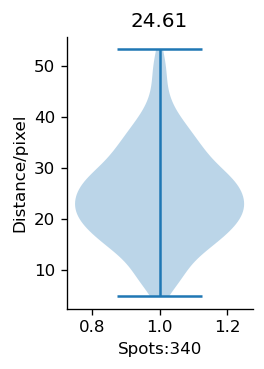

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Figure size 432x288 with 0 Axes>

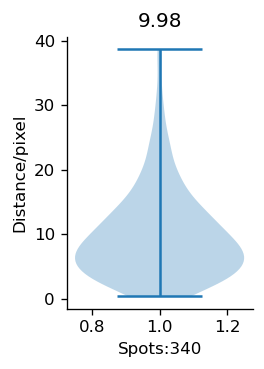

<Figure size 432x288 with 0 Axes>

In [228]:
result_ransac,icp_p2p = ransac_points_registration(A,B,dist_raw)
dist_icp = violin_distance(A, B)
result = copy.deepcopy(source)
result.transform(icp_p2p.transformation)

s=np.asarray(result.points)[:,:3]#convert spot physical coordinates to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='probreg_icp', size=1,
                  face_color='magenta',edge_color='magenta',blending='opaque')
dist_icp = violin_distance(A, s)

# #gfit=o3d.pipelines.registration.evaluate_registration(source,target,threshold,tf_param.rot)
# print("result: ", np.rad2deg(t3d.euler.mat2euler(tf_param.rot)),tf_param.scale, tf_param.t)

# # from scipy.spatial import KDTree
# # target_tree = KDTree(target, leafsize=10)
# # rmse = math_utils.compute_rmse(source, target_tree)

# print("Error (m): ")
# print(norm(np.rad2deg(t3d.euler.mat2euler(tf_param.rot) - tf_param.t)))

### Validate all paired cells are similar in shape and size

339


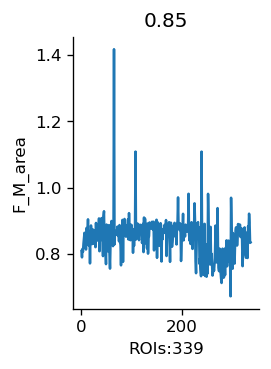

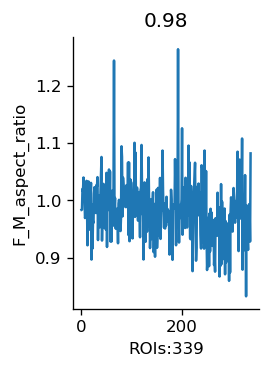

100.0


In [99]:
out_dir = seg_dir + 'allroi_matched.csv'

B_icp = np.column_stack((C, ROI_points_mov[:,3]))
Bind,Aind = pair_match(B_icp,ROI_points_fix,3*dist_raw) # set the fix roi order 

Bind = Aind # Default

print(len(Bind))
H = Aind
F_M_area = np.empty([len(H), 1])
F_M_aspect_ratio = np.empty([len(H), 1])
df_filtered_fix = df_filtered1
df_filtered_mov = df_filtered2

### examine the correspondence 
for i in range(0,len(H)):
    # area
    F_M_area[i] = (df_filtered_fix.loc[i]['area']
                   /df_filtered_mov.loc[i]['area'])
    #aspect_ratio
    F_M_aspect_ratio[i] = (df_filtered_fix.loc[i]['aspect_ratio']
                   /df_filtered_mov.loc[i]['aspect_ratio'])

fig=plt.figure(dpi=120,figsize=(2,3))
plt.plot(F_M_area)
sns.despine() 
plt.xlabel('ROIs:'+ str(F_M_area.shape[0]))
plt.ylabel('F_M_area')
ave=np.average(F_M_area)
plt.title(str(float('%.2f' % ave)))
plt.show()

fig=plt.figure(dpi=120,figsize=(2,3))
plt.plot(F_M_aspect_ratio)
sns.despine() 
plt.xlabel('ROIs:'+ str(F_M_aspect_ratio.shape[0]))
plt.ylabel('F_M_aspect_ratio')
ave=np.average(F_M_aspect_ratio)
plt.title(str(float('%.2f' % ave)))
plt.show()

### remove the bad correspondence for the wrong area and aspect_ratio
a = np.where(F_M_aspect_ratio>2)[0]
b = np.where(F_M_aspect_ratio<0.5)[0]
c = np.where(F_M_area>2)[0]
d = np.where(F_M_area<0.5)[0]

# find the MOV ROI ID of corespond to FIX using pair
badROI = list(set(a)|set(b)|set(c)|set(d))
# all match
badROI = []

okROI = list(set(list(range(len(Aind)))).difference(set(badROI)))
print(len(okROI)/len(Aind)*100)
df = pd.DataFrame(np.empty([len(okROI), 0]))

# Aind = ROI_points_fix

df['fix'] = Aind[okROI]
# df['mov'] = Bind[okROI] # all match
df['mov'] = Aind[okROI] # default match
df.to_csv(out_dir, index=False)

### Remove wrong correspondence (not necessary)

In [ ]:
A = ROI_points_fix[okROI,:3]
viewer.add_points(np.transpose(np.array([A[:,0],A[:,1],A[:,2]])),name ='fixed_ROI', size=1,
                  face_color='green',edge_color='green',blending='opaque') 
B = B_icp[okROI,:3]
viewer.add_points(np.transpose(np.array([B[:,0],B[:,1],B[:,2]])),name ='moving_ROI', size=1,
                  face_color='magenta',edge_color='magenta',blending='opaque') 

H = Aind[okROI]
F_M_area = np.empty([len(H), 1])
F_M_aspect_ratio = np.empty([len(H), 1])
for i in range(0,len(H)):
    # area
    F_M_area[i] = (df_filtered_fix.loc[Aind[okROI][i]-1]['area']
                   /df_filtered_mov.loc[Bind[okROI][i]-1]['area'])
    #aspect_ratio
    F_M_aspect_ratio[i] = (df_filtered_fix.loc[Aind[okROI][i]-1]['aspect_ratio']
                   /df_filtered_mov.loc[Bind[okROI][i]-1]['aspect_ratio'])
    
fig=plt.figure(dpi=120,figsize=(2,3))
plt.plot(F_M_area)
sns.despine() 
plt.xlabel('ROIs:'+ str(F_M_area.shape[0]))
plt.ylabel('F_M_area')
ave=np.average(F_M_area)
plt.title(str(float('%.2f' % ave)))
plt.show()

fig=plt.figure(dpi=120,figsize=(2,3))
plt.plot(F_M_aspect_ratio)
sns.despine() 
plt.xlabel('ROIs:'+ str(F_M_aspect_ratio.shape[0]))
plt.ylabel('F_M_aspect_ratio')
ave=np.average(F_M_aspect_ratio)
plt.title(str(float('%.2f' % ave)))
plt.show()

## Later analysis for generate ROI_spots once the extracted spots has been updated

In [11]:
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/' # 
r1 = ['R2','R1'][0]
lb_1 = imread(seg_dir + r1 + '_filtered_mask.tif')
out_dir = seg_dir + r1 + '_mergeroi.csv'
df_filtered1,ROI_points_fix = ROI_meta(lb_1,out_dir)
np.savetxt(seg_dir + r1 + 'ROI_points_fix.txt', ROI_points_fix, delimiter=',')   # X is an array

(340, 4)


In [24]:
# all matched ROI
out_dir = seg_dir + 'allroi_matched.csv'
Aind = ROI_points_fix[:,3]
df = pd.DataFrame(np.empty([len(Aind), 0]))
df['fix'] = Aind.astype(int)
# df['mov'] = Bind[okROI] # all match
df['mov'] = Aind.astype(int)# default match
df.to_csv(out_dir, index=False)

In [100]:
%%time
# import all packages
from glob import glob
from skimage.io import imread, imsave
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/' # 
r = ['R2','R1']
s = [0.92,0.92,0.84]

# #hAir
# for i in [0]:
#     segmentation = imread(seg_dir + r[i] + '_filtered_mask.tif')
#     spot_dir = seg_dir + r[i] + '_3tm50_1920/*.txt'
#     count = ROI_spot(seg_dir,segmentation,spot_dir,r[i],s)    
#     out_dir = seg_dir + r[i] + '_allroi.csv'
#     df_filtered,_ = ROI_meta(segmentation,out_dir)
#     puncta_path = seg_dir + r[i] + '_3tm50_1920/stitching/export.n5'
#     _,_ = ROI_intensity(segmentation,puncta_path, r[i], df_filtered)
    
#RS-FISH
for i in [0,1]:
    segmentation = imread(seg_dir + r[i] + '_filtered_mask.tif')
    spot_dir = seg_dir + 'RS-FISH/'+ r[i] + '_c*.txt'
#     spot_dir = seg_dir + 'RS-FISH/'+ r[i] + '_c3.txt'
    count = ROI_spot(seg_dir,segmentation,spot_dir,r[i],s)   
    out_dir = seg_dir + 'RS-FISH/'+ r[i] + '_allroi.csv'
    df_filtered,_ = ROI_meta(segmentation,out_dir)

Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R2_c0.txt
(123365, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R2_c1.txt
(453, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R2_c2.txt
(511354, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R2_c3.txt
(157765, 5)
(340, 4)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R1_c0.txt
(137036, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R1_c1.txt
(42, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R1_c2.txt
(654287, 5)
Load: E:/Maxprobe_analysis/R2_R1_3tm50/RS-FISH\R1_c3.txt
(150991, 5)
(340, 4)
CPU times: total: 4min 8s
Wall time: 4min 19s


# Adapt the matched ROI for later analysis

In [ ]:
ROI_ransac_napari_fixmovROI.ipynb

In [48]:
# fixed_spots1.shape
fixed_spots2_0.shape[0],fixed_spots2_1.shape[0],fixed_spots2_2.shape[0]

(154, 4, 1468)

In [45]:
Chn = ["c0","c1","c3"]

spotdir2_0 = seg_dir + 'RS-FISH/R2_' + Chn[0] + '_ROI.txt'
spotdir1_0 = seg_dir + 'RS-FISH/R1_' + Chn[0] + '_ROI.txt'
spotdir2_1 = seg_dir + 'RS-FISH/R2_' + Chn[1] + '_ROI.txt'
spotdir1_1 = seg_dir + 'RS-FISH/R1_' + Chn[1] + '_ROI.txt' 
spotdir2_2 = seg_dir + 'RS-FISH/R2_' + Chn[2] + '_ROI.txt'
spotdir1_2 = seg_dir + 'RS-FISH/R1_' + Chn[2] + '_ROI.txt'

# read all spots and add color label to the spots.    
spot_fix2_0 = np.loadtxt(spotdir2_0, delimiter=',')
fixed_spots2_0 = spot_fix2_0[spot_fix2_0[:,4] == ROI_fixed][:,:3]
spot_mov1_0=np.loadtxt(spotdir1_0, delimiter=',')
moving_spots1_0 = spot_mov1_0[spot_mov1_0[:,4] == ROI_moving][:,:3]
fixed_spots2_0 = np.column_stack((fixed_spots2_0,0 * np.ones(fixed_spots2_0.shape[0])))
moving_spots1_0 = np.column_stack((moving_spots1_0,0 * np.ones(moving_spots1_0.shape[0])))

spot_fix2_1 = np.loadtxt(spotdir2_1, delimiter=',')
fixed_spots2_1 = spot_fix2_1[spot_fix2_1[:,4] == ROI_fixed][:,:3]
spot_mov1_1=np.loadtxt(spotdir1_1, delimiter=',')
moving_spots1_1 = spot_mov1_1[spot_mov1_1[:,4] == ROI_moving][:,:3] 
fixed_spots2_1 = np.column_stack((fixed_spots2_1,1 * np.ones(fixed_spots2_1.shape[0])))
moving_spots1_1 = np.column_stack((moving_spots1_1,1 * np.ones(moving_spots1_1.shape[0])))

spot_fix2_2 = np.loadtxt(spotdir2_2, delimiter=',')
fixed_spots2_2 = spot_fix2_2[spot_fix2_2[:,4] == ROI_fixed][:,:3]
spot_mov1_2=np.loadtxt(spotdir1_2, delimiter=',')
moving_spots1_2 = spot_mov1_2[spot_mov1_2[:,4] == ROI_moving][:,:3]         
fixed_spots2_2 = np.column_stack((fixed_spots2_2,2 * np.ones(fixed_spots2_2.shape[0])))
moving_spots1_2 = np.column_stack((moving_spots1_2,2 * np.ones(moving_spots1_2.shape[0])))

fixed_spots1 = np.vstack([fixed_spots2_0,fixed_spots2_1,fixed_spots2_2])
moving_spots1 = np.vstack([moving_spots1_0,moving_spots1_1,moving_spots1_2])

## RANSAC registration

In [ ]:
def ransac_align_points(
    pA, pB, threshold, diagonal_constraint=0.75, default=np.eye(4)[:3],
):
    """
    """

    # sensible requirement of 51 or more spots to compute ransac affine
    if len(pA) <= 4 or len(pB) <= 4:
        if default is not None:
            print("Insufficient spot matches for ransac, returning default identity")
            return default
        else:
            raise ValueError("Insufficient spot matches for ransac, need more than 4")

    # compute the affine
    r, Aff, inline = cv2.estimateAffine3D(pA.astype(float), pB.astype(float), ransacThreshold=threshold, confidence=0.999)
    print(np.diag(Aff))
    print(Aff)
#     print(diagonal_constraint)
    # rarely ransac just doesn't work (depends on data and parameters)
    # sensible choices for hard constraints on the affine matrix
    if np.any( np.diag(Aff) < diagonal_constraint ):
        if default is not None:
            print("Degenerate affine produced, returning default identity")
            return default
        else:
            raise ValueError("Degenerate affine produced, ransac failed")

    return Aff
# match points, then ransac
# ransac

align_threshold = dist_raw*2
global_affine = ransac_align_points(A, B1, align_threshold)
inv_Transform = ransac_align_points(B1, A, align_threshold)
print(global_affine)
p = np.append(B1, np.ones((B1.shape[0],1)), axis=1)
ROI_points_icp_ransac = p.dot(inv_Transform.T)

G = ROI_points_icp_ransac[:,:3]
viewer.add_points(np.transpose(np.array([G[:,0],G[:,1],G[:,2]])),name ='RANSAC_ROI', size=1,
                  face_color='red',edge_color='red',blending='opaque') 
dist_ICP_Ransac = violin_distance(A, G)

## Find the match points by ICP registration

In [ ]:
Transform, distances1 = icp(A, B1, dist_raw)
inv_Transform, distances2 = icp(B1, A, dist_raw)
p = np.append(B1, np.ones((B1.shape[0],1)), axis=1)
ROI_points_warp = p.dot(inv_Transform.T)[:,:3]
C = ROI_points_warp[:,:3]
viewer.add_points(np.transpose(np.array([C[:,0],C[:,1],C[:,2]])),name ='ICP_ROI', size=1,
                  face_color='red',edge_color='red',blending='opaque')
dist_ICP = violin_distance(A, C)

In [ ]:
# match points, then ransac
match_threshold = dist_ICP*2
D, E = match_points(A, C, 0, match_threshold)

# ransac
align_threshold = dist_ICP*2
global_affine = ransac.ransac_align_points(D, E, align_threshold,)
inv_Transform = ransac.ransac_align_points(E, D, align_threshold,)
print(global_affine)
p = np.append(C, np.ones((C.shape[0],1)), axis=1)
ROI_points_icp_ransac = p.dot(inv_Transform.T)
ROI_points_icp_ransac[:,3] = ROI_points_mov[:,3]

G = ROI_points_icp_ransac[:,:3]
viewer.add_points(np.transpose(np.array([G[:,0],G[:,1],G[:,2]])),name ='RANSAC_ROI', size=1,
                  face_color='red',edge_color='red',blending='opaque') 
dist_ICP_Ransac = violin_distance(A, G)

# CPD

In [ ]:
import copy
import numpy as np
import open3d as o3
from probreg import cpd
import transforms3d as t3d

def estimate_normals(pcd, params):
    pcd.estimate_normals(search_param=params)
    pcd.orient_normals_to_align_with_direction()# load source and target point cloud

source = o3.io.read_point_cloud('D:/0_software/github/probreg/examples/bunny.pcd')
source.remove_non_finite_points()
target = copy.deepcopy(source)

# read points of # point cloud
# xyz = np.asarray(result.points)

A = A
B = s

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
# pcd = o3.geometry.PointCloud()
target.points = o3.utility.Vector3dVector(A)
source.points = o3.utility.Vector3dVector(B)
# o3.io.write_point_cloud("../../test_data/sync.ply", pcd)
# o3.visualization.draw_geometries(pcd)

# register
tf_param, _, _ = cpd.registration_cpd(source, target)
result = copy.deepcopy(source)
result.points = tf_param.transform(result.points)

# draw result
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0.5, 1])
o3.visualization.draw_geometries([result,source])

# draw result with napari
# s=np.asarray(source.points)[:,:3]#convert spot physical coordinates to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='A', size=1,
#                   face_color='green',edge_color='green',blending='opaque')
# s=np.asarray(target.points)[:,:3]#convert spot physical coordinates to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='B', size=1,
#                   face_color='yelow',edge_color='yellow',blending='opaque')
s=np.asarray(result.points)[:,:3]#convert spot physical coordinates to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='cpd', size=1,
                  face_color='magenta',edge_color='magenta',blending='opaque')

dist_cpd = violin_distance(A, s)

## RANSAC registration

#resultglobaltran = tf_param
#gfit=o3d.pipelines.registration.evaluate_registration(source,target,threshold,tf_param.rot)

#fitness=gfit.fitness
#rmse=gfit.inlier_rmse
#cdots=len(gfit.correspondence_set)

# print("result: ", np.rad2deg(t3d.euler.mat2euler(tf_param.rot)),
#       tf_param.scale, tf_param.t)

# from scipy.spatial import KDTree
# target_tree = KDTree(target, leafsize=10)
# rmse = math_utils.compute_rmse(source, target_tree)

# print("Error (m): ")
# print(norm(np.rad2deg(t3d.euler.mat2euler(tf_param.rot) - tf_param.t)))

In [232]:
print("result: ", np.rad2deg(t3d.euler.mat2euler(tf_param.rot)),
      tf_param.scale, tf_param.t)

from scipy.spatial import KDTree
target_tree = KDTree(target, leafsize=10)
rmse = math_utils.compute_rmse(source, target_tree)

print("Error (m): ")
print(norm(np.rad2deg(t3d.euler.mat2euler(tf_param.rot) - tf_param.t)))

result:  [-1.07629591  0.7265069   1.0515532 ] 1.0154113631585333 [ -0.53387308 -14.4904109    6.87017962]


TypeError: float() argument must be a string or a number, not 'open3d.cpu.pybind.geometry.PointCloud'

# ICP

In [ ]:
# source.paint_uniform_color([1, 0, 0])
# target.paint_uniform_color([0, 1, 0])
# result.paint_uniform_color([0, 0.5, 1])
threshold = 0.05 # how to set initially
icp_iteration = 200
result = copy.deepcopy(source)
for i in range(icp_iteration):
    reg_p2p = o3.pipelines.registration.registration_icp(result, target, threshold,
                np.identity(4), o3.pipelines.registration.TransformationEstimationPointToPoint(),
                o3.pipelines.registration.ICPConvergenceCriteria(max_iteration=10))
    result.transform(reg_p2p.transformation)
#     vis.update_geometry(source)
#     vis.update_geometry(target)
#     vis.update_geometry(result)
#     vis.poll_events()
# vis.run()

# result.points = tf_param.transform(result.points)
# o3.visualization.draw_geometries([result,source,target])
s=np.asarray(result.points)[:,:3]#convert spot physical coordinates to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='probreg_icp', size=1,
                  face_color='magenta',edge_color='magenta',blending='opaque')

dist_cpd = violin_distance(A, s)

## Find the match points by Descriptor

In [ ]:
def random_spots_in_radius(n_spots, n_dim, radius):
    """
    get random relative (integer) coordinates within radius
    """
    
    if np.isscalar(radius):
        radius = np.array([radius] * n_dim)
    else:
        radius = np.array(radius)
    
    res_spots = []
    while len(res_spots) < n_spots:
        # uniformly distributed on hypersquare
        candidate = [np.random.randint(-radius[i],radius[i]+1) for i in range(len(radius))]
        # reject spots not in hypersphere
        if (np.sum(np.array(candidate)**2 / radius**2) <= 1):
            res_spots.append(candidate)

    return np.array(res_spots)

def match_kd(descs_a, descs_b):
    kd = KDTree(descs_a)
    ds, idxes = kd.query(descs_b)
    return idxes

def match_la(descs_a, descs_b):
    
    descs_a = np.array(descs_a)
    print(descs_a[0])
    descs_b = np.array(descs_b)
        
    n_spots_max = np.max([descs_a.shape[0], descs_b.shape[0]])
    n_spots_a = descs_a.shape[0]
    n_spots_b = descs_b.shape[0]
    
    # pad for empty assignment
    if (n_spots_b > n_spots_a):
        descs_a = np.concatenate((descs_a, descs_b[descs_a.shape[0]:]))
    if (n_spots_b < n_spots_a):
        descs_b = np.concatenate((descs_b, descs_a[descs_b.shape[0]:]))
    
    print (descs_a[0])
#     print (descs_b)
    a = np.tile(descs_a, [n_spots_max, 1] )
    b = np.repeat(descs_b, n_spots_max, 0)
    ds = np.sqrt(np.sum((a-b)**2, axis=1)).reshape((n_spots_max, n_spots_max))
    print(ds)
    
    _, idxes_la = linear_sum_assignment(ds)
    idxes_la[idxes_la>=n_spots_a] = -1
    return idxes_la[:n_spots_b]

In [ ]:
# calculate distance or related angle of n nearest points, to each points
# calculte the correlation of each points, set a threshold to find match points
# https://github.com/PreibischLab/bigstitcher-benchmark/blob/master/src/main/python/descriptor_test.ipynb
# https://github.com/PreibischLab/BigStitcher/blob/master/src/main/java/net/preibisch/stitcher/process/ICPRefinement.java
# https://github.com/fiji/Descriptor_based_registration

import json
import numpy as np
from scipy.spatial import KDTree
from scipy.optimize import linear_sum_assignment
#np.random.seed(42)

def _stats(arr):
    """
    """

    # compute mean and standard deviation along columns
#     arr = arr.astype(np.float64)
    means = np.mean(arr, axis=1)
    sqr_means = np.mean(np.square(arr), axis=1)
    stddevs = np.sqrt( sqr_means - np.square(means) )
    return means, stddevs
        
def pairwise_correlation(ds_A, ds_B):
    """
    """
    # get means and std for all contexts, center contexts
    a_mean, a_std = _stats(ds_A)
    b_mean, b_std = _stats(ds_B)
    a_con = ds_A- a_mean[..., None]
    b_con = ds_B - b_mean[..., None]

    # compute pairwise correlations
    corr = np.matmul(a_con, b_con.T)
    corr = corr / a_std[..., None]
    corr = corr / b_std[None, ...]
    corr = corr / a_con.shape[1]

    # contexts with no variability are nan, set to 0
    corr[np.isnan(corr)] = 0
    return corr

def match_points(A, B, scores, threshold):
    """
    """

    # split positions from context
    a_pos = np.array( [a for a in A] )
    b_pos = np.array( [b for b in B] )

    # get highest scores above threshold
    best_indcs = np.argmax(scores, axis=1)
    a_indcs = range(len(a_pos))
    keeps = scores[(a_indcs, best_indcs)] > threshold

    # return positions of corresponding points
    return a_pos[keeps, :3], b_pos[best_indcs[keeps], :3]

def get_descriptor(spot, spots, neighbors_for_descriptor):
    kd = KDTree(spots)
    ds, idxs = kd.query(spot, k=neighbors_for_descriptor+1)
    d_vecs = spot - spots[idxs[1:]]
    desc = d_vecs.flatten()
    return desc

def get_descriptor_ds (spot, spots, neighbors_for_descriptor):
    kd = KDTree(spots)
    ds, idxs = kd.query(spot, k=neighbors_for_descriptor+1)
    d_vecs = spot - spots[idxs[1:]]
    desc = d_vecs.flatten()
    return ds[1:]

neighbors_for_descriptor = 12
spots = A[:,:3].copy()
descs_A = [get_descriptor(s, spots, neighbors_for_descriptor) for s in spots]
ds_A = [get_descriptor_ds(s, spots, neighbors_for_descriptor) for s in spots]
spots_t = B[:,:3].copy()
descs_B = [get_descriptor(s, spots_t, neighbors_for_descriptor) for s in spots_t]
ds_B = [get_descriptor_ds(s, spots, neighbors_for_descriptor) for s in spots]


# get point correspondences may change to mutual information
match_threshold = 0.4
correlations = pairwise_correlation(ds_A, ds_B)
A1, B1 = match_points(A, B,correlations, match_threshold,)
print(f'Found {B1.shape[0]} matched fixed points')

idxes = match_kd(descs_A, descs_B)
idxes_la = match_la(descs_A, descs_B)

print(np.unique(idxes).shape)
print(np.unique(idxes_la).shape)
# print(idxes_la[0:10])
print(A1[0])
dist_raw = violin_distance(A, B1)